# Anomaly Detection in Lymphoma Patients

In this notebook we will explore a dataset that describes the medical condition of Lymphoma patients!
We will also implement some anomaly detection algorithms as we do not have domain knowledge in this field.

There are three different kinds of outliers:
1. Global outliers:
A data point is considered a global outlier if its value is far outside the entirety of the data set in which it is found.
2. Contextual outliers:
A data point is considered a contextual outlier if its value significantly deviates from the rest the data points in the same context.
3. Collective outliers:
A subset of data points within a data set is considered anomalous if those values as a collection deviate significantly from the entire data set, but the values of the individual data points are not themselves anomalous in either a contextual or global sense.

We will focus our project on global outliers since we do not fundementally understand the context of the data and we don't have enough data to inspect any collective anomalies.

## Background
Diffuse large B-cell lymphoma (DLBCL) is an aggressive type of non-Hodgkin lymphoma that develops from the B-cells in the lymphatic system. Under the microscope, large malignant lymphocytes are seen diffusely throughout the specimen. <br/>
Often the first symptom of DLBCL is a painless swelling in the neck, armpit or groin that is caused by enlarged lymph nodes. These lumps can grow quite quickly, often over a period of a few weeks.  Sometimes, other parts of the body are also affected. This is known as ‘extranodal’ disease because it is happening outside of the lymph nodes, and includes the stomach or bowel being affected, which may cause abdominal discomfort or pain, diarrhoea or bleeding. 

## Our Goal 
To get rid of outliers in the most effecient way so we can build the optimal classifer whether the patient has extranodal sites or not.

## Import Libraries

In [1]:
#!pip install missingno
#!pip install pandas_profiling
#!pip install rfpimp
#!pip install xgboost

In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
import rfpimp
import missingno as msno
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import MinCovDet
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from IPython import display
from mpl_toolkits.mplot3d import Axes3D
import pickle
from main import Initial_pre_processing_Transformer, FeatureTransformer, numeric_Transformer, cat_Transformer, OHEcol, ipi_values_Transformer

In [3]:
np.random.seed(711)
random_state_seed = 711

In [4]:
df = pd.read_csv('prognostics_dev.csv', skiprows=range(517,521),index_col=0)

In [5]:
df.rename(columns={"Treatment__": "Treatment", "Status at Follow_up_ 0 Alive_ 1 Dead": "Follow up Status Alive=0 Dead=1", "Follow_up Time _yrs": "Follow up Time (yrs)", "Progression_Free Survival _PFS_ Status_ 0 No Progressoin_ 1 Progression": "PFS Status No Progress=0 Progress=1", "Progression_Free Survival _PFS_ Time _yrs": "PFS (yrs)"}, inplace=True)

### Data Exploration and Cleaning

In [6]:
df.head()

dbGaP submitted subject ID dbGaP accession                      Diagnosis  \
0                 DLBCL11202       phs001444  Diffuse large B cell lymphoma   
1                 DLBCL10484       phs001444  Diffuse large B cell lymphoma   
2                 DLBCL10555       phs001444  Diffuse large B cell lymphoma   
3                 DLBCL10942       phs001444  Diffuse large B cell lymphoma   
4                 DLBCL10566       phs001444  Diffuse large B cell lymphoma   

  Gene Expression Subgroup Genetic Subtype    Biopsy Type           Treatment  \
0                  Unclass           Other  Pre-treatment  Immunochemotherapy   
1                      GCB           Other  Pre-treatment  Immunochemotherapy   
2                      GCB             EZB  Pre-treatment  Immunochemotherapy   
3                  Unclass             BN2  Pre-treatment  Immunochemotherapy   
4                  Unclass           Other  Pre-treatment  Immunochemotherapy   

  Gender   Age  Ann Arbor Stage  LDH Ratio  ECOG Performance Status  \
0      M  32.0              4.0       2.02                      2.0   
1      F  54.0              1.0       0.77                      0.0   
2      F  68.0              3.0       0.66                      3.0   
3      F  60.0              1.0       0.89                      1.0   
4      M  23.0              2.0       0.73                      0.0   

   Number of Extranodal Sites     IPI Group  IPI Range  \
0                         1.0  Intermediate          3   
1                         0.0           Low          0   
2                         0.0  Intermediate          3   
3                         NaN           Low          1   
4                         1.0           Low          0   

   Follow up Status Alive=0 Dead=1  Follow up Time (yrs)  \
0                                0              6.001369   
1                                0              8.651608   
2                                0              9.916496   
3                                0              8.449008   
4                                0             10.548939   

   PFS Status No Progress=0 Progress=1  PFS (yrs)  \
0                                    0   6.001369   
1                                    0   8.651608   
2                                    0   9.916496   
3                                    0   8.449008   
4                                    0  10.548939   

  Included in Survival Analysis  
0                           Yes  
1                           Yes  
2                           Yes  
3                           Yes  
4                           Yes

Our data contains 520 observations and 21 features.

In [7]:
df.shape

(516, 20)

we have noticed that on the last 4 rows there is  some explanation about the values in the data that will later on may be helpful: <br/>
NA: not available <br/>
IPI range groups: 0-1 (low); 2-3 (intermediate); 4-5 (high).  If some IPI components are missing and the range of the IPI would fall between these groups, this parameter is left blank and the case was not used for the IPI analysis. <br/>
Chemoimmunotherapy: CHOP or CHOP-like chemotherapy plus Rituximab!

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516 entries, 0 to 573
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   dbGaP submitted subject ID           516 non-null    object 
 1   dbGaP accession                      516 non-null    object 
 2   Diagnosis                            516 non-null    object 
 3   Gene Expression Subgroup             516 non-null    object 
 4   Genetic Subtype                      516 non-null    object 
 5   Biopsy Type                          516 non-null    object 
 6   Treatment                            213 non-null    object 
 7   Gender                               516 non-null    object 
 8   Age                                  507 non-null    float64
 9   Ann Arbor Stage                      406 non-null    float64
 10  LDH Ratio                            319 non-null    float64
 11  ECOG Performance Status         

### Feature Description <br/>

After asking a MD to calrify the meaning of the features we came up with this:  <br/>
dbGaP submitted subject ID - A single human person/individual/patient that arises from a single germline. Each subject is submitted with a single, unique, de-identified subject ID. Subjects submitted to dbGaP <br/>
dbGaP accession - An accession number in bioinformatics is a unique identifier given to a DNA or protein sequence record to allow for tracking of different versions of that sequence record and the associated sequence over time in a single data repository. <br/>
Diagnosis - The specific type of cancer <br/>
Gene Expression Subgroup - A subtype of lymphoma, any subtype that is each affected differently by chemotherapy.
Genetic Subtype - The gene that the mutation he makes cause Lymphoma.
Biopsy Type  If value is "pre-treatment" that means biopsy speciman was taken before the patient's treatment. If the value is "relapsed" that means the speciman was taken after the patient already had Lymphoma. <br/>
Treatment - The kind of treatment that was given to the patient  <br/>
Gender - The patient's gender  <br/>
Age - The patient's age in years  <br/>
Ann Arbor Stage - A unique lymphoma staging classification system from 1 to 4  <br/>
LDH ratio - The level of lactate dehydrogenase (LDH) in the blood  <br/>
ECOG Performance Status - Describes a patient’s level of functioning in terms of their ability to care for themself from 0 to 5  <br/>
Number of Extranodal Sites - The number of a nodal cancer metastasis beyond the confines of the capsule of a lymph node into adjacent tissues.  <br/>
IPI Group - A categorical presentation of IPI range.
0-1 (low); 2-3 (intermediate); 4-5 (high). If some IPI components are missing and the range of the IPI would fall between these groups, this parameter is left blank and the case was not used for the IPI analysis. <br/>
IPI Range - clinical tool developed by oncologists to aid in predicting the prognosis of patients with aggressive non-Hodgkin's lymphoma from 0 to 5  <br/>
Follow up Status Alive=0 Dead=1 - Wheather the person was alive or not in the follow up. <br/>
Follow up Time (years) - Is measured from time zero (the start of the study or from the point at which the participant is considered to be at risk) until the study ends or the participant is lost.  <br/>
PFS status - Wheather the person showed progress since the treatment was given.  <br/>
PFS time (years) - the length of time during and after the treatment of a disease that a patient lives with the disease but it does not get worse.  <br/>
Included in survival analysis - Wheather the person was included in the survival analysis.  <br/>

In [9]:
df.describe()

Age  Ann Arbor Stage   LDH Ratio  ECOG Performance Status  \
count  507.000000       406.000000  319.000000               370.000000   
mean    60.631164         2.697044    1.650776                 1.452703   
std     14.660454         1.075239    2.261324                 1.104220   
min     14.000000         0.000000   -1.000000                 0.000000   
25%     51.000000         2.000000    0.817143                 1.000000   
50%     62.000000         3.000000    1.120000                 1.000000   
75%     72.000000         4.000000    1.879474                 2.000000   
max     91.000000         4.000000   30.760000                 5.000000   

       Number of Extranodal Sites   IPI Range  \
count                  387.000000  516.000000   
mean                     0.828165    8.201550   
std                      0.993271    9.998936   
min                      0.000000    0.000000   
25%                      0.000000    2.000000   
50%                      1.000000    4.000000   
75%                      1.000000   13.000000   
max                      6.000000   45.000000   

       Follow up Status Alive=0 Dead=1  Follow up Time (yrs)  \
count                       516.000000            516.000000   
mean                          0.162791              2.051069   
std                           0.369533              3.565394   
min                           0.000000              0.000000   
25%                           0.000000              0.000000   
50%                           0.000000              0.000000   
75%                           0.000000              2.398357   
max                           1.000000             16.424367   

       PFS Status No Progress=0 Progress=1   PFS (yrs)  
count                           516.000000  511.000000  
mean                              0.186047    1.839213  
std                               0.389522    3.434606  
min                               0.000000    0.000000  
25%                               0.000000    0.000000  
50%                               0.000000    0.000000  
75%                               0.000000    1.457589  
max                               1.000000   16.424367

## Visualization

In [10]:
variable_report = ProfileReport(df=df,progress_bar=False,samples=None, missing_diagrams=None, duplicates=None, interactions=None)
# We calculated correlations & missing diagrams by ourselves (below) to show programming abilities & generate good-looking visualizations :)
# Getting information about the data, such as: type, unique values, missing values, quantile statistics, mean, mode, median, standard deviation, sum, skewness, frequent values, histograms, correlation between variables, count etc.

variable_report

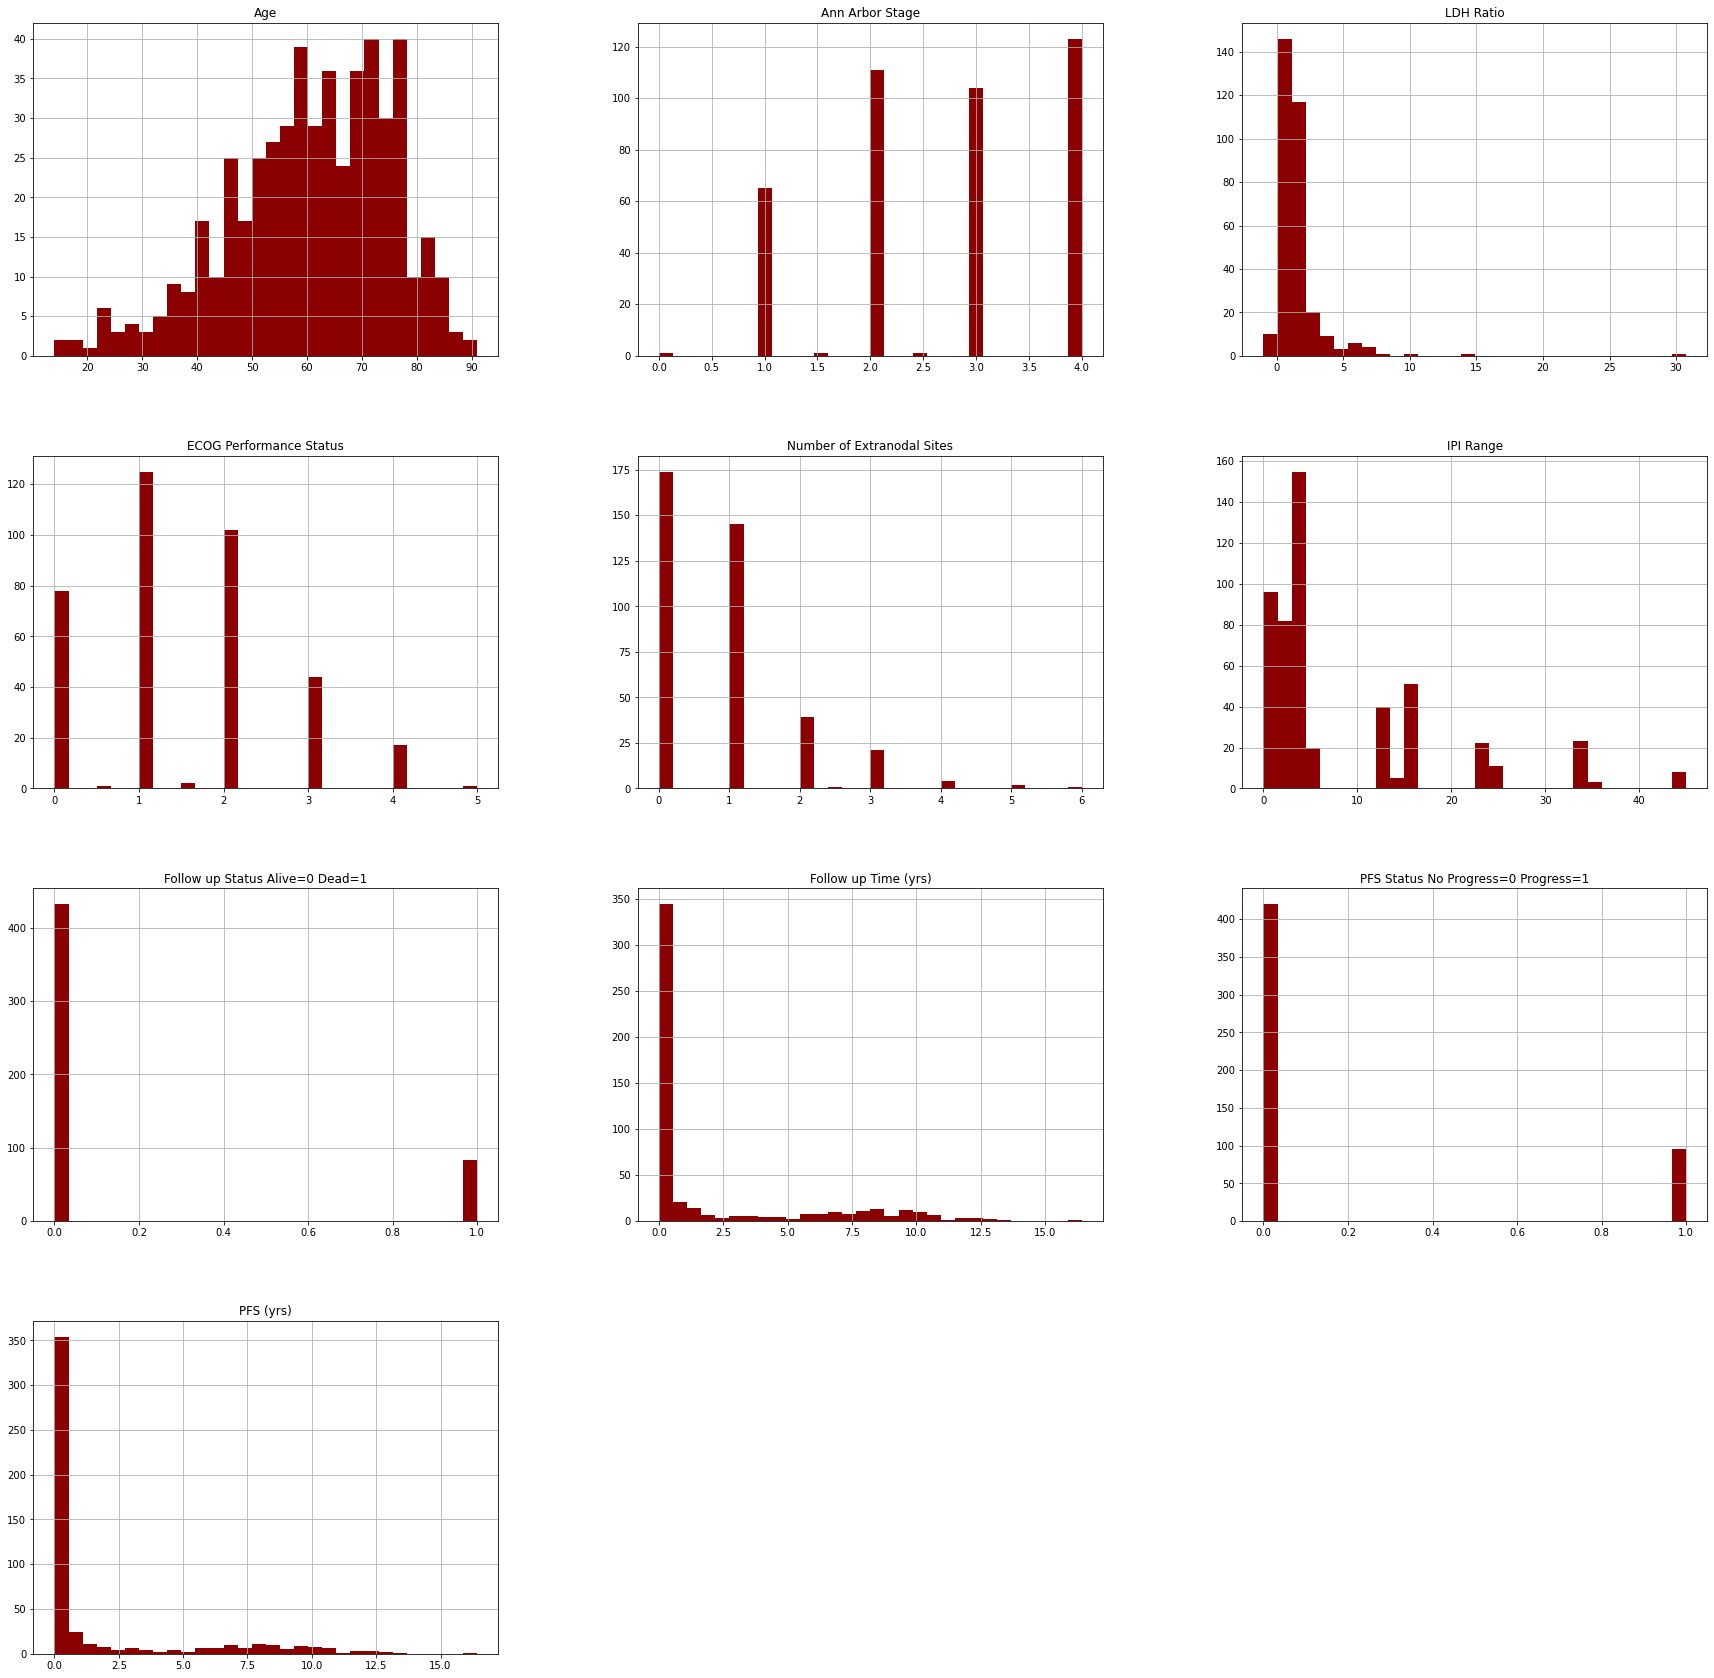

In [11]:
# visualization of numeric features
df.hist(figsize=(30,30), bins=30, color='darkred')
plt.show()

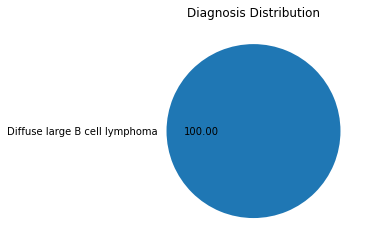

In [12]:
fig, ax = plt.subplots()
df.groupby('Diagnosis').size().plot(kind='pie', autopct='%.2f')
ax.set_ylabel("")
ax.set_title("Diagnosis Distribution")
plt.show()

we can see that all of the patients have the same diagnosis, so we can get rid of this column

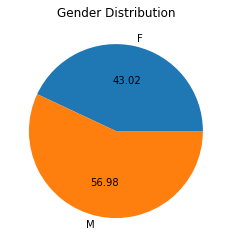

In [13]:
fig, ax = plt.subplots()
df.groupby('Gender').size().plot(kind='pie', autopct='%.2f')
ax.set_ylabel("")
ax.set_title("Gender Distribution")
plt.show()

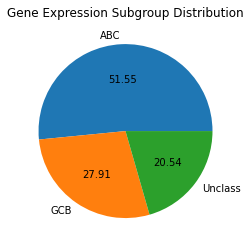

In [14]:
fig, ax = plt.subplots()
df.groupby('Gene Expression Subgroup').size().plot(kind='pie', autopct='%.2f')
ax.set_ylabel("")
ax.set_title("Gene Expression Subgroup Distribution")
plt.show()

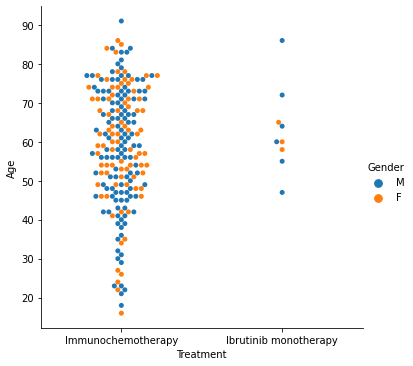

In [15]:
sns.catplot(x="Treatment", y="Age", hue="Gender", kind="swarm", data=df)
plt.show()

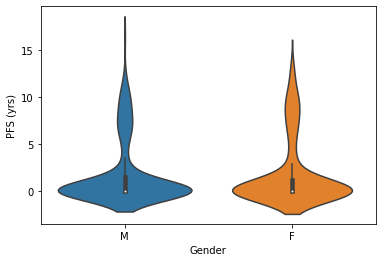

In [16]:
sns.violinplot(x="Gender", y="PFS (yrs)", hue=None, data=df)
plt.show()

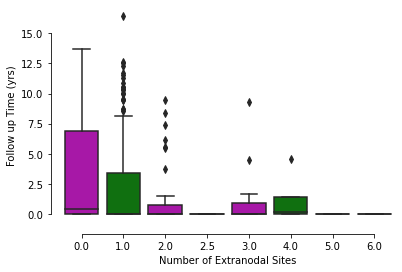

In [17]:
sns.boxplot(y="Follow up Time (yrs)", x="Number of Extranodal Sites", palette=["m", "g"],
            data=df)
sns.despine(offset=10, trim=True)
plt.show()

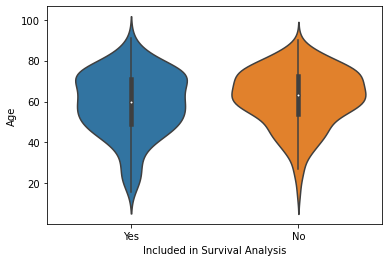

In [18]:
sns.violinplot(x="Included in Survival Analysis", y="Age", hue=None, data=df)
plt.show()

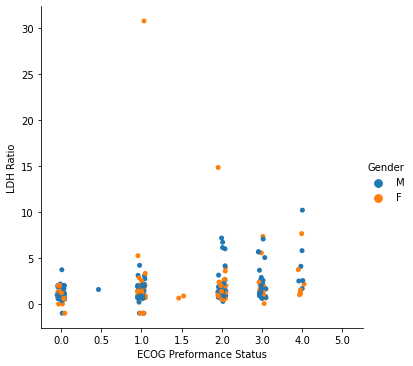

In [19]:
g = sns.catplot(
    data=df,
    x="ECOG Performance Status", y="LDH Ratio", hue="Gender",
    height=5)

# Use more informative axis labels than are provided by default
g.set_axis_labels("ECOG Preformance Status", "LDH Ratio")
plt.show()

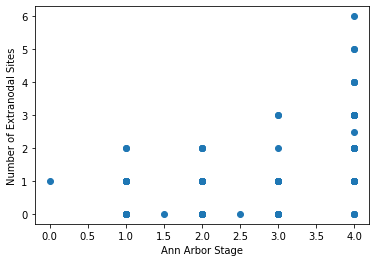

In [20]:
plt.plot( df["Ann Arbor Stage"],df["Number of Extranodal Sites"], "o")
plt.ylabel("Number of Extranodal Sites")
plt.xlabel("Ann Arbor Stage")
plt.show()

In [21]:
# We can see that we can that there is a lot of mutual information between the IPI Range & IPI Group
# We can infer the group by looking at the range
# We can verify our assumption that there are IPI values that are entered as ranges (45 instead of 4-5)
df.groupby('IPI Group')[['IPI Range']].agg(['mean', 'min', 'max','unique'])

IPI Range                    
                  mean min max      unique
IPI Group                                 
High          9.296875   4  45  [4, 5, 45]
Intermediate  5.186747   2  23  [3, 2, 23]
Low           0.656250   0   1      [0, 1]

In [22]:
# Calculate target - for visualization purposes. Is also used calculated during preprocessing
df['binary_num_of_nodes'] = df['Number of Extranodal Sites'].copy()

# Change only the not-null values
not_null_node_indices = df[~df['Number of Extranodal Sites'].isna()].index
df.loc[not_null_node_indices,'binary_num_of_nodes'] = np.where(df.loc[not_null_node_indices,:]['Number of Extranodal Sites']>0, 1, 0)

****************************
Gene Expression Subgroup
****************************


<Figure size 720x216 with 0 Axes>

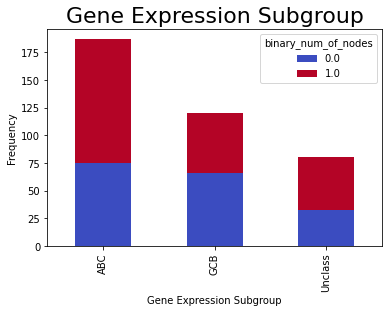

****************************
Genetic Subtype
****************************


<Figure size 720x216 with 0 Axes>

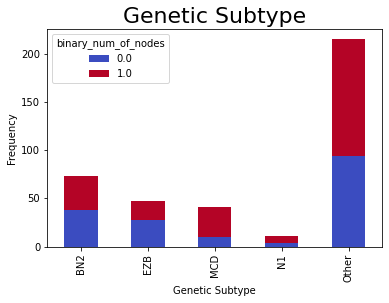

****************************
Biopsy Type
****************************


<Figure size 720x216 with 0 Axes>

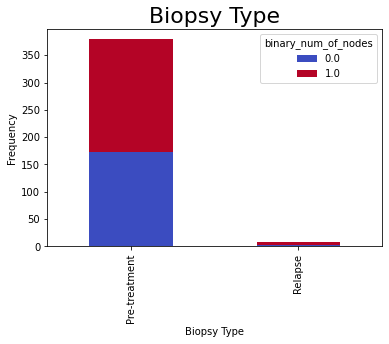

****************************
Treatment
****************************


<Figure size 720x216 with 0 Axes>

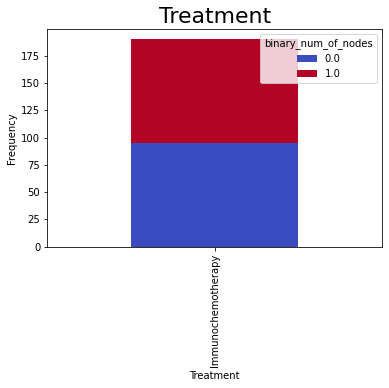

****************************
Gender
****************************


<Figure size 720x216 with 0 Axes>

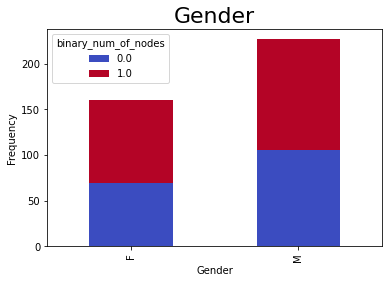

****************************
Age
****************************


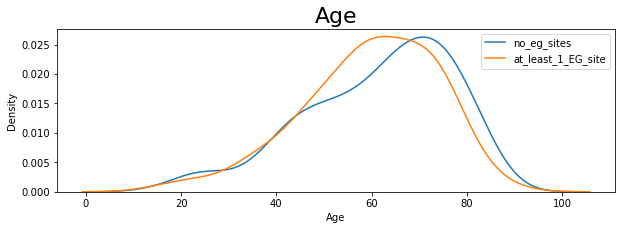

****************************
Ann Arbor Stage
****************************


<Figure size 720x216 with 0 Axes>

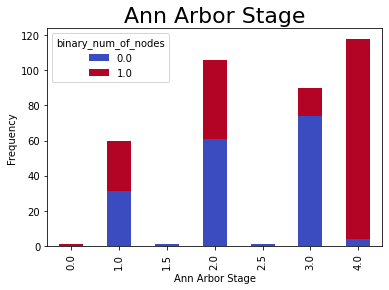

****************************
LDH Ratio
****************************


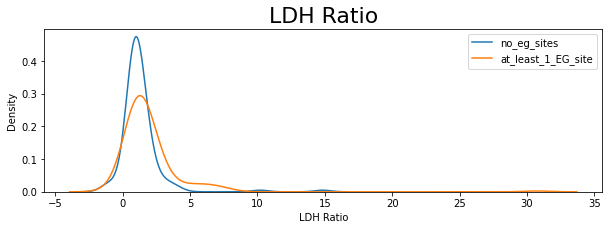

****************************
ECOG Performance Status
****************************


<Figure size 720x216 with 0 Axes>

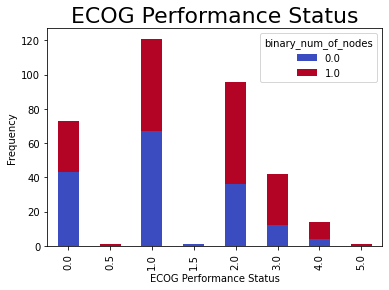

****************************
IPI Group
****************************


<Figure size 720x216 with 0 Axes>

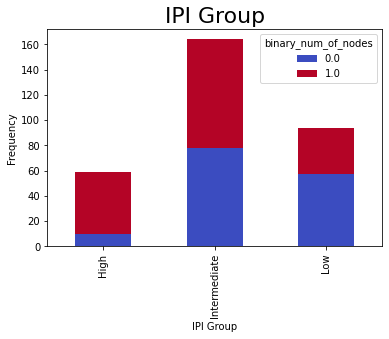

****************************
IPI Range
****************************


<Figure size 720x216 with 0 Axes>

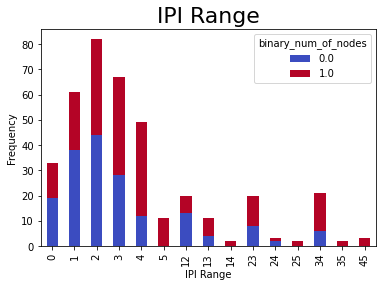

****************************
Follow up Status Alive=0 Dead=1
****************************


<Figure size 720x216 with 0 Axes>

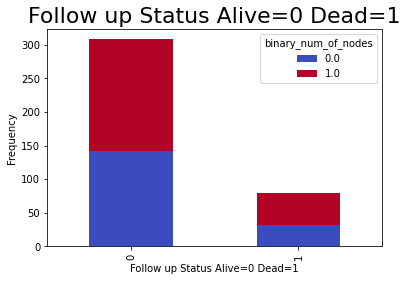

****************************
Follow up Time (yrs)
****************************


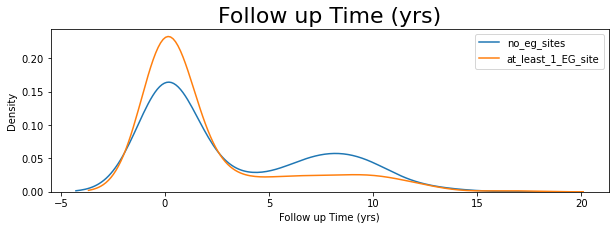

****************************
PFS Status No Progress=0 Progress=1
****************************


<Figure size 720x216 with 0 Axes>

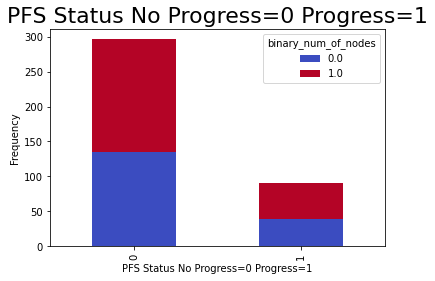

****************************
PFS (yrs)
****************************


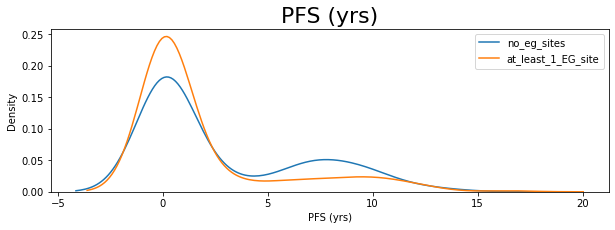

****************************
Included in Survival Analysis
****************************


<Figure size 720x216 with 0 Axes>

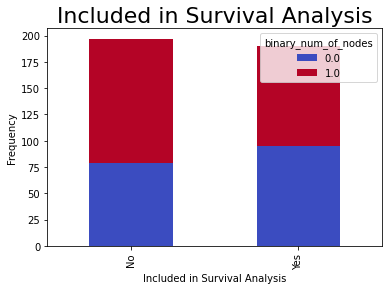

In [23]:
# KDE plots for continuous variables, histograms for discrete

features_to_plot = ['Gene Expression Subgroup', 'Genetic Subtype', 'Biopsy Type',
       'Treatment', 'Gender', 'Age', 'Ann Arbor Stage', 'LDH Ratio',
       'ECOG Performance Status','IPI Group',
       'IPI Range', 'Follow up Status Alive=0 Dead=1', 'Follow up Time (yrs)',
       'PFS Status No Progress=0 Progress=1', 'PFS (yrs)',
       'Included in Survival Analysis']

# Density Plot w.r.t label
def density_plots(df, features):
    '''
    For each feature in features: returns a histogram/density plot (if discrete/continuous, respectively) given the data in df
    Parameters
    ----------
    None
    Returns
    ----------
    Plots
        histogram/density plots for each feature in features
    '''
    for col in features:
        print ('****************************')
        print (col)
        print ('****************************')
        plt.figure(figsize=(10, 3))
        # continuous features
        if col in ('Age','LDH Ratio','Follow up Time (yrs)','PFS (yrs)'):
            sns.kdeplot(df.loc[df.binary_num_of_nodes == False, col], label='no_eg_sites')
            sns.kdeplot(df.loc[df.binary_num_of_nodes == True, col], label='at_least_1_EG_site')
            plt.title(col, fontsize=22)
            plt.legend()
            plt.show()
        else:
            no_nans_df = df[[col, 'binary_num_of_nodes']].dropna()
            plot_hist(no_nans_df, col)
            plt.show()

def plot_hist(df, feature):
    '''
    Plots a histogram for the input feature given the data in df
    Parameters
    ----------
    None
    Returns
    ----------
    Histogram
        Histogram on feature
    '''    
    colors = [plt.cm.coolwarm_r(float(i)) for i in range(1,-1,-1)]
    x = df.pivot_table(index=feature, columns='binary_num_of_nodes', aggfunc='size')
    x.plot(kind='bar',stacked=True,color=colors,legend=True)
    
#     x_copy = x.copy()
#     x_copy['sum'] = x_copy.sum(axis=1)
#     x_copy['False_%'] = x_copy.iloc[:,0]/x_copy['sum']
#     x_copy['True_%'] = x_copy.iloc[:,1]/x_copy['sum']
#     x_copy.loc[:,["True_%","False_%"]].plot(kind='bar',stacked=True,legend=False)
    
    # Decoration
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title(feature, fontsize=22)
    plt.show()
density_plots(df, features_to_plot);

# Preproccesing

In [24]:
Initial_pre_processing_Transformer = Initial_pre_processing_Transformer()
df_after_preprocessing, y = Initial_pre_processing_Transformer.fit_transform(df)

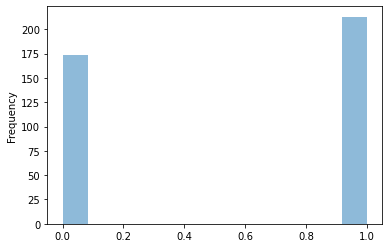

In [25]:
ax = y.plot.hist(bins=12, alpha=0.5)

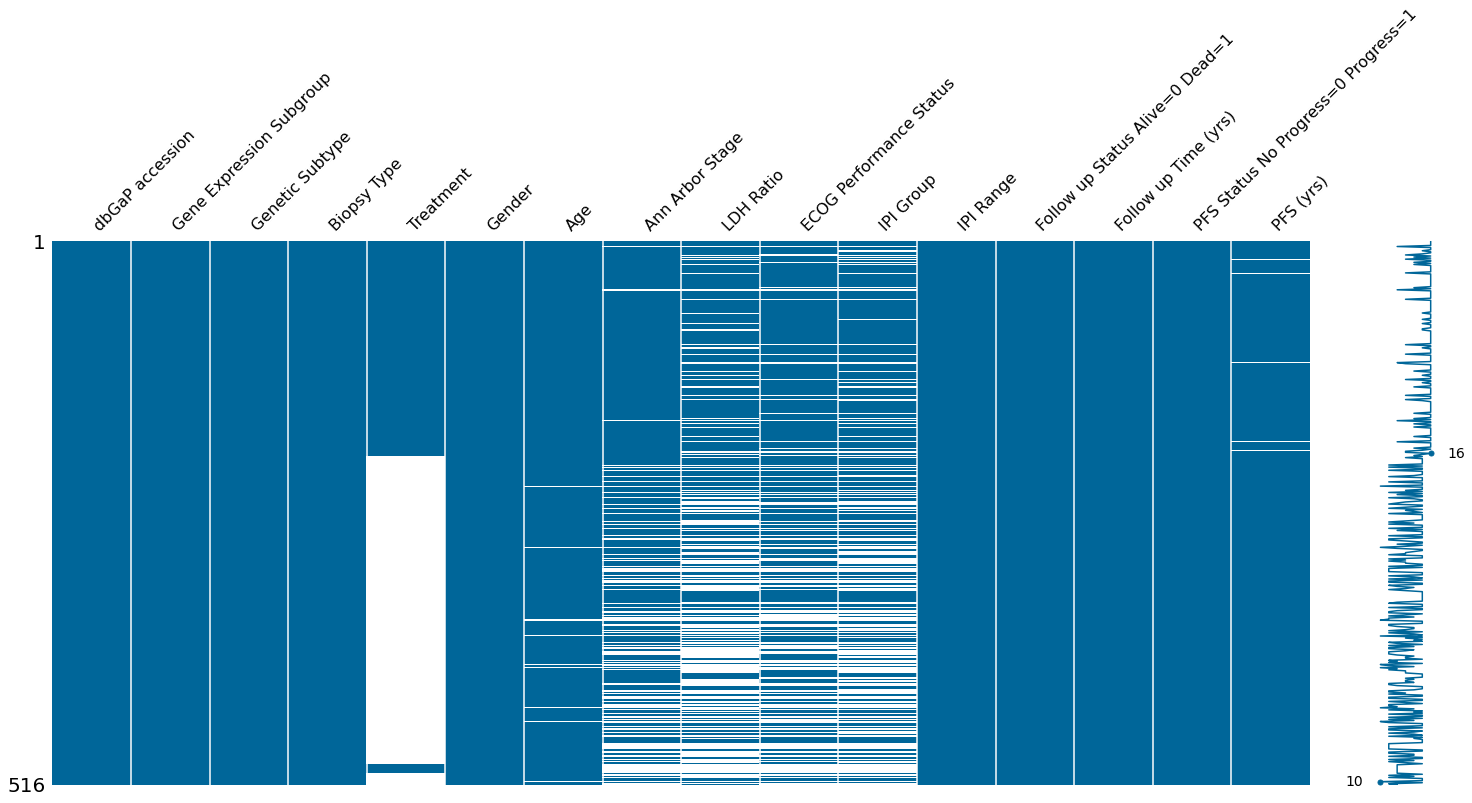

In [26]:
missing_color = (0, 0.4, 0.6)
msno.matrix(df_after_preprocessing,color=missing_color)
plt.show()

In [27]:
pd.set_option('display.max_columns', None)
feature_transformer = FeatureTransformer()
feature_transformer.fit(df_after_preprocessing)
pickle.dump(feature_transformer, open('feature_transformer.pkl', 'wb'))
x_transformed = pd.DataFrame(feature_transformer.transform(df_after_preprocessing).A,index=df_after_preprocessing.index,columns=feature_transformer.get_feature_names())
# x_test = pd.DataFrame(feature_transformer.transform(df_after_preprocessing).A,index=df_after_preprocessing.index,columns=feature_transformer.get_feature_names())
x_transformed.head(10)

/Users/linb/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


num__ann arbor stage  num__ldh ratio  num__ecog performance status  \
0                    4.0            2.02                           2.0   
1                    1.0            0.77                           0.0   
2                    3.0            0.66                           3.0   
3                    1.0            0.89                           1.0   
4                    2.0            0.73                           0.0   
5                    3.0            1.12                           1.0   
6                    3.0            1.73                           2.0   
8                    4.0            1.49                           2.0   
9                    3.0            2.00                           1.0   
10                   2.0            1.07                           1.0   

    num__gender  num__age  num__follow up status alive=0 dead=1  \
0           0.0      32.0                                   0.0   
1           1.0      54.0                                   0.0   
2           1.0      68.0                                   0.0   
3           1.0      60.0                                   0.0   
4           0.0      23.0                                   0.0   
5           1.0      74.0                                   0.0   
6           1.0      78.0                                   1.0   
8           0.0      66.0                                   1.0   
9           1.0      69.0                                   0.0   
10          1.0      55.0                                   0.0   

    num__follow up time (yrs)  num__pfs status no progress=0 progress=1  \
0                    6.001369                                       0.0   
1                    8.651608                                       0.0   
2                    9.916496                                       0.0   
3                    8.449008                                       0.0   
4                   10.548939                                       0.0   
5                    6.105407                                       0.0   
6                    1.924709                                       1.0   
8                    0.867899                                       1.0   
9                    0.438056                                       0.0   
10                  10.707734                                       0.0   

    num__pfs (yrs)  __gene expression subgroup__abc  \
0         6.001369                              0.0   
1         8.651608                              0.0   
2         9.916496                              0.0   
3         8.449008                              0.0   
4        10.548939                              0.0   
5         6.105407                              0.0   
6         1.111567                              0.0   
8         0.785763                              0.0   
9         0.438056                              1.0   
10       10.707734                              0.0   

    __gene expression subgroup__gcb  __gene expression subgroup__unclass  \
0                               0.0                                  1.0   
1                               1.0                                  0.0   
2                               1.0                                  0.0   
3                               0.0                                  1.0   
4                               0.0                                  1.0   
5                               1.0                                  0.0   
6                               0.0                                  1.0   
8                               1.0                                  0.0   
9                               0.0                                  0.0   
10                              1.0                                  0.0   

    __biopsy type__pretreatment  __treatment__immunochemotherapy  \
0                           1.0                              1.0   
1                           1.0               

<AxesSubplot:>

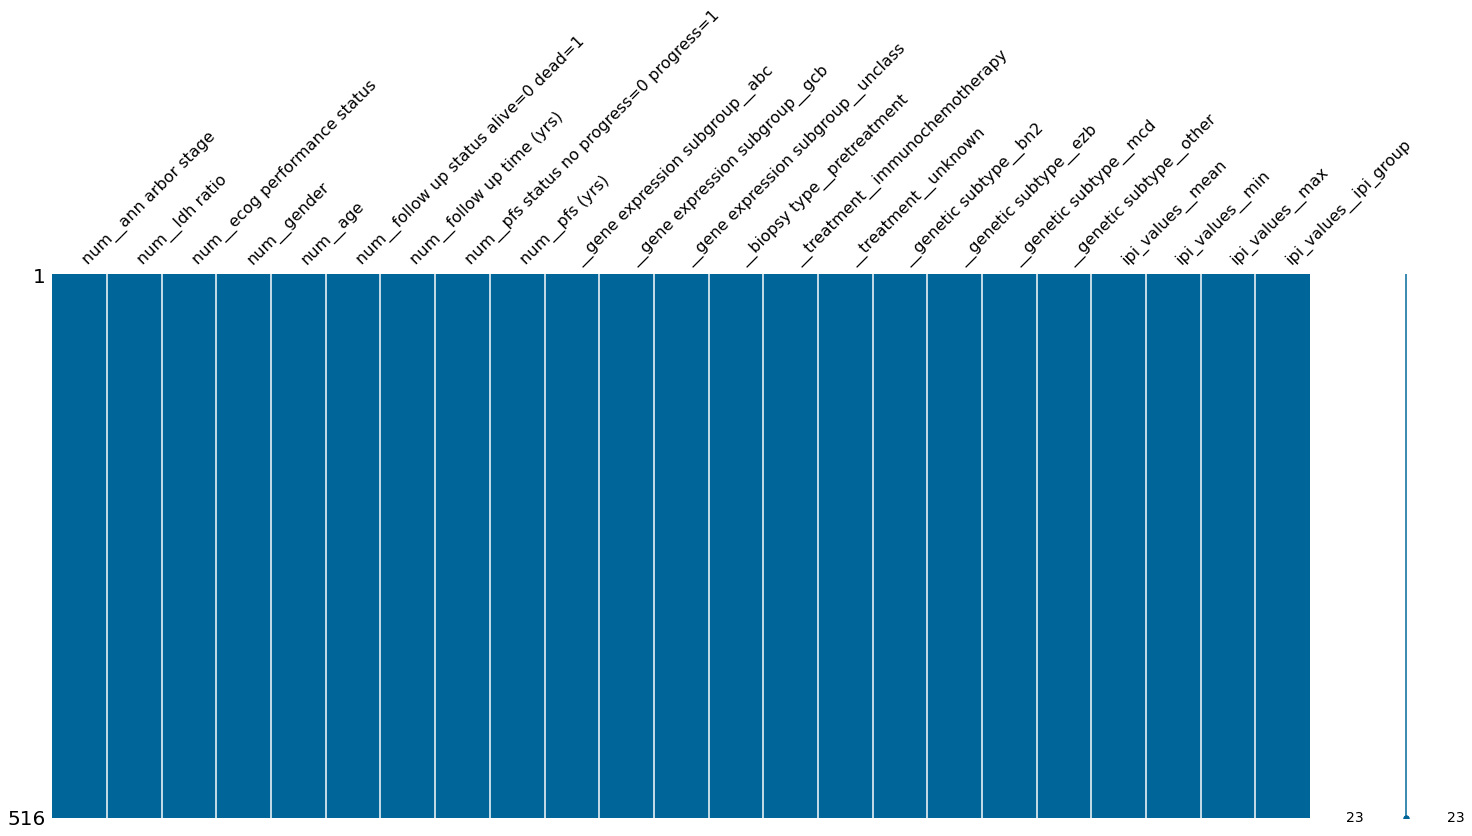

In [28]:
missing_color = (0, 0.4, 0.6)
msno.matrix(x_transformed,color=missing_color)

In [29]:
y_binary_isunlabeled = np.array(y.isna().tolist())
y_unlabeled_unscaled = y[y_binary_isunlabeled]
X_unlabled_unscaled = x_transformed[y_binary_isunlabeled]
y_labeled_unscaled = y[~y_binary_isunlabeled]
X_labeled_unscaled = x_transformed[~y_binary_isunlabeled]
X_train_labeled_unscaled, X_test_labeled_unscaled, y_train_labeled, y_test_labeled = train_test_split(X_labeled_unscaled, y_labeled_unscaled, test_size=0.25, random_state=random_state_seed)

## Standartization

As our project mainly deals with outlier detection. We decided to normalize our model using min_max_scaler

In [30]:
minmaxScalerX = MinMaxScaler()
X_train_labeled = pd.DataFrame(minmaxScalerX.fit_transform(X_train_labeled_unscaled),columns=X_train_labeled_unscaled.columns)
pickle.dump(minmaxScalerX, open('minmaxScalerX.pkl', 'wb'))
X_test_labeled = pd.DataFrame(minmaxScalerX.transform(X_test_labeled_unscaled), columns=X_test_labeled_unscaled.columns)
X_unlabled = pd.DataFrame(minmaxScalerX.transform(X_unlabled_unscaled), columns=X_unlabled_unscaled.columns)
X_train_labeled.head()

num__ann arbor stage  num__ldh ratio  num__ecog performance status  \
0                  0.50        0.054156                           0.2   
1                  0.25        0.037783                           0.2   
2                  0.75        0.059824                           0.2   
3                  1.00        0.066751                           0.8   
4                  1.00        0.066751                           0.0   

   num__gender  num__age  num__follow up status alive=0 dead=1  \
0          1.0  0.818182                                   0.0   
1          0.0  0.623377                                   0.0   
2          0.0  0.493506                                   1.0   
3          1.0  0.792208                                   0.0   
4          1.0  0.389610                                   0.0   

   num__follow up time (yrs)  num__pfs status no progress=0 progress=1  \
0                   0.000000                                       0.0   
1                   0.090348                                       0.0   
2                   0.164027                                       1.0   
3                   0.000000                                       0.0   
4                   0.000000                                       0.0   

   num__pfs (yrs)  __gene expression subgroup__abc  \
0        0.000000                              0.0   
1        0.090348                              0.0   
2        0.115686                              0.0   
3        0.000000                              1.0   
4        0.000000                              1.0   

   __gene expression subgroup__gcb  __gene expression subgroup__unclass  \
0                              1.0                                  0.0   
1                              0.0                                  1.0   
2                              1.0                                  0.0   
3                              0.0                                  0.0   
4                              0.0                                  0.0   

   __biopsy type__pretreatment  __treatment__immunochemotherapy  \
0                          1.0                              0.0   
1                          1.0                              1.0   
2                          1.0                              1.0   
3                          1.0                              0.0   
4                          1.0                              0.0   

   __treatment__unknown  __genetic subtype__bn2  __genetic subtype__ezb  \
0                   0.0                     0.0                     0.0   
1                   0.0                     1.0                     0.0   
2                   0.0                     0.0                     1.0   
3                   0.0                     0.0                     0.0   
4                   0.0                     0.0                     0.0   

   __genetic subtype__mcd  __genetic subtype__other  ipi_values__mean  \
0                     0.0                       1.0               0.2   
1                     0.0                       0.0               0.2   
2                     0.0                       0.0               0.2   
3                     1.0                       0.0               0.9   
4                     0.0                       1.0               0.3   

   ipi_values__min  ipi_values__max  ipi_values__ipi_group  
0              0.2              0.2                    0.0  
1              0.2              0.2                    0.0  
2              0.2              0.2                    0.0  
3              0.8              1.0                    1.0  
4              0.2              0.4                    0.0

## Feature Selection

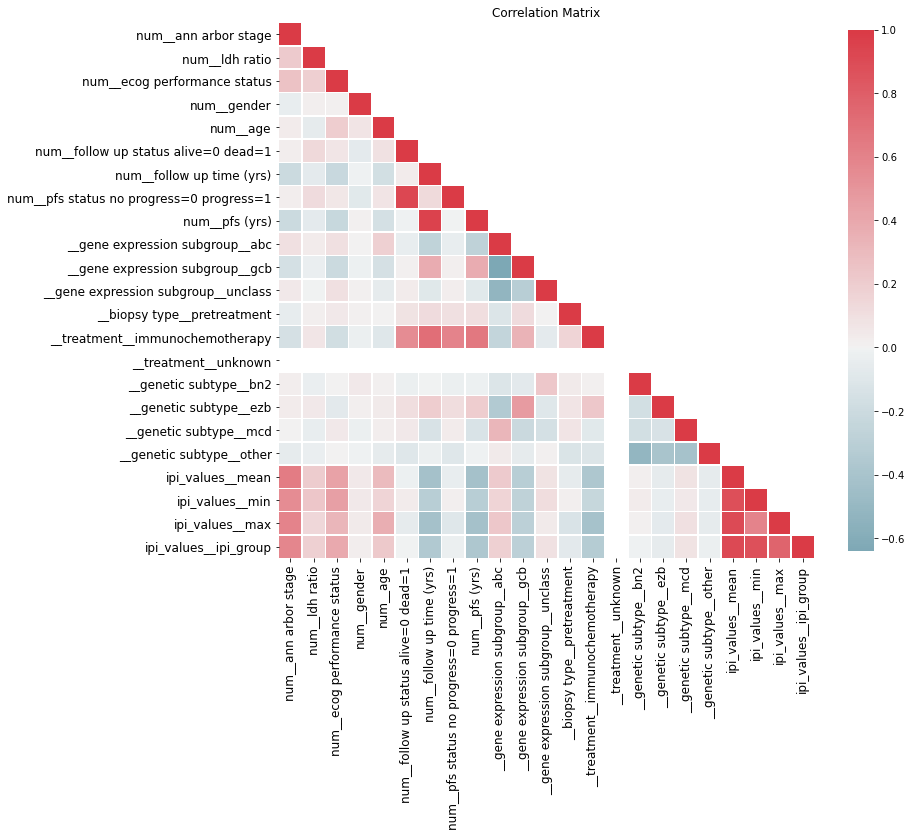

In [31]:
def plot_correlation_matrix(data, numeric_features):
    '''
    Compute pairwise correlation of columns & plot Triangular correlation Matrix

    Parameters
    ----------
    1) data:  DataFrame
    2) numeric_features: List of numeric featuers to compute 
    
    Returns
    ----------
    Plot
    Returns the plotted correlation matrix
    '''     
    cor_mat = data[numeric_features].corr()
    corr_left_triangle = cor_mat.where(np.tril(np.ones(cor_mat.shape)).astype(np.bool))
    # Generate a mask for the upper triangle
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 12))
    # Generate a custom diverging colormap
    ax.set_facecolor('xkcd:white')
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.heatmap(corr_left_triangle, cmap=cmap, vmax=1, center=0,  # vmax=max_correlation
                square=True, linewidths=.5, cbar_kws={"shrink": 0.8})
    plt.title("Correlation Matrix")
    plt.show()
    
plot_correlation_matrix(x_transformed,x_transformed.columns)

### Permutation Importance

In [32]:
perm_imp = rfpimp.cv_importances(X_train = X_train_labeled, y_train = y_train_labeled, k=3, model=XGBClassifier(eval_metric='auc', use_label_encoder=False, n_jobs=-1, random_state = random_state_seed))
perm_imp_df = perm_imp.reset_index().copy()

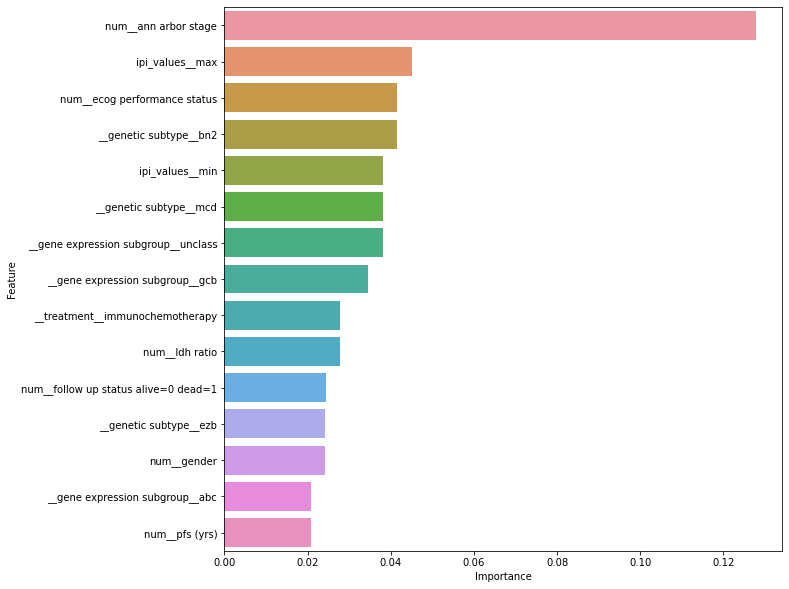

In [33]:
plt.figure(figsize=(10, 10))
# sns.barplot(x="Importance",y="Feature",data=perm_imp_df[perm_imp_df.Importance>0.0005])
sns.barplot(x="Importance",y="Feature",data=perm_imp_df[0:15])


plt.show()

### Random Forest Importance

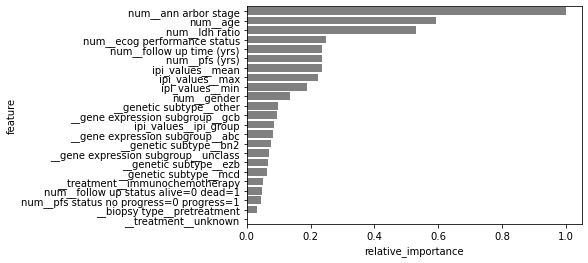

In [34]:
forestImportance = RandomForestClassifier(n_estimators=100)
forestImportance.fit(X_train_labeled, y_train_labeled.values.ravel())
feature_importance = forestImportance.feature_importances_  

forest_importance_df = pd.DataFrame(list(zip(X_train_labeled.columns, feature_importance / feature_importance.max())), columns=['feature', 'relative_importance']).sort_values('relative_importance', ascending=False)

top_i = 40 # Choose how many features we want to plot
# Features in red are the random features we've created for comparison during feature importance
clrs = ['red' if ('random' in x) else 'gray' for x in forest_importance_df.feature]
sns.barplot(data=forest_importance_df.iloc[0:top_i,:],x="relative_importance", y="feature",palette=clrs)
plt.show()

In [35]:
def estimate_model(model, X_train, y_train, X_test, y_test):    
    '''
    Computes train accuracy, AUC, test accuracy

    Parameters
    ----------
    1) model:  Classifier
    2) X_train: DataFrame/Matrix
    3) y_train: pd.series. vector of 1/0
    4) X_test: DataFrame/Matrix
    5) y_test: pd.series. vector of 1/0
    
    Returns
    ----------
    train_accuracy, AUC, test_accuracy
    ''' 
    model.fit(X_train,y_train)
    train_accuracy = model.score(X_train, y_train)
    try:
        y_pred = model.predict_proba(X_test)[:,1]
    except: 
        y_pred = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    auc = metrics.auc(fpr,tpr)
    test_accuracy = metrics.accuracy_score(y_test, np.round(y_pred))        
    return train_accuracy, auc, test_accuracy

In [36]:
results = []
features_by_importance = perm_imp_df['Feature'].tolist()
train_acc_score = []
auc_score = []
test_acc_score = []

for k in range(1, len(features_by_importance)+1):
    # Choose model
    clf = RandomForestClassifier()
    scores = estimate_model(clf, X_train_labeled[features_by_importance[:k]], y_train_labeled, X_test_labeled[features_by_importance[:k]], y_test_labeled)
    results.append(scores[1])
    # summarize the results
    print('>%d features: train accuracy score %.3f, auc score %.3f,  test accuracy score %.3f' % (k, scores[0], scores[1], scores[2]))
    train_acc_score.append(scores[0])
    auc_score.append(scores[1])
    test_acc_score.append(scores[2])

>1 features: train accuracy score 0.734, auc score 0.809,  test accuracy score 0.742
>2 features: train accuracy score 0.766, auc score 0.793,  test accuracy score 0.732
>3 features: train accuracy score 0.821, auc score 0.819,  test accuracy score 0.742
>4 features: train accuracy score 0.845, auc score 0.821,  test accuracy score 0.701
>5 features: train accuracy score 0.852, auc score 0.825,  test accuracy score 0.680
>6 features: train accuracy score 0.866, auc score 0.802,  test accuracy score 0.680
>7 features: train accuracy score 0.876, auc score 0.825,  test accuracy score 0.722
>8 features: train accuracy score 0.897, auc score 0.820,  test accuracy score 0.794
>9 features: train accuracy score 0.924, auc score 0.792,  test accuracy score 0.711
>10 features: train accuracy score 0.979, auc score 0.812,  test accuracy score 0.742
>11 features: train accuracy score 0.979, auc score 0.801,  test accuracy score 0.763
>12 features: train accuracy score 0.983, auc score 0.799,  tes

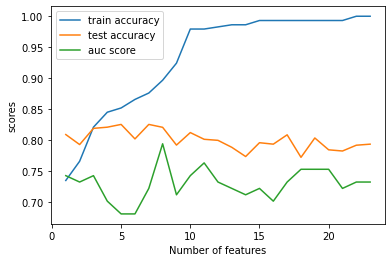

In [37]:
plt.plot(range(1, len(features_by_importance)+1), train_acc_score, label = 'train accuracy')
plt.plot(range(1, len(features_by_importance)+1), auc_score, label = 'test accuracy')
plt.plot(range(1, len(features_by_importance)+1), test_acc_score, label = 'auc score')
plt.xlabel('Number of features')
plt.ylabel('scores')
plt.legend(loc="upper left")
plt.show()

In [38]:
print("As we can see the model with the highest auc score is a model based on ",np.argmax(results) +1, "features which are:", features_by_importance[:np.argmax(results)+1] )
most_imp_feat =  features_by_importance[:np.argmax(results)+1]

As we can see the model with the highest auc score is a model based on  5 features which are: ['num__ann arbor stage', 'ipi_values__max', 'num__ecog performance status', '__genetic subtype__bn2', 'ipi_values__min']


We examined two feature selection models, we decided to continue with the first model as it is showing us the score gain for every feature compared to a random values feature.
In addition, random forest classiefier gives priority to numeric continuous features as there are more threasholds to give them.

In [39]:
all_features = list(X_train_labeled.columns)
top_5_feat = perm_imp_df[0:5].Feature.values
permutation_importance_features = perm_imp_df[0:15].Feature.values

## Outlier Detection

### Model 1 - Minimum Covariance Determinant

One way to detect anomalies is to assume that regular (non-anomalous) data are generated by a particular probability distribution, and to declare points with low probability density as anomalies. For ellipitically distributed (e.g. Gaussian) data, this can be done by computing the Mahalanobis distance from each point to the mean, and defining anomalies as points with with distance above some threshold. The Mahalanobis distance requires the parameters of the distribution (mean and covariance matrix). Since these are unknown, they must be estimated from the data.

Mahalanobis distance = $\Delta^2=(\boldsymbol{x}^i-\boldsymbol{x}^j)^\top\Sigma^{-1}(\boldsymbol{x}^i-\boldsymbol{x}^j)$

In [40]:
mcd_train = MinCovDet(random_state = random_state_seed)
non_test_x = pd.concat([X_train_labeled, X_train_labeled])
mcd_train.fit(non_test_x)
d_train = mcd_train.mahalanobis(X_train_labeled)

/Users/linb/opt/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


In [41]:
train_rslt= []
test_rslt= []
auc_rslt = []
clf = RandomForestClassifier(random_state = 1)

#we will examine the accuracy of every precentile threshold
for k in range(50,100,1):
    threshold_train = np.percentile(d_train, k)
    mask_train_mahalanobis = d_train > threshold_train
    #clean outliers from train data
    temp_x_train = X_train_labeled[~mask_train_mahalanobis]
    temp_y_train = y_train_labeled[~mask_train_mahalanobis]
#     #train the model after outliers was moved
#     train_accuracy,auc,test_accuracy = estimate_model(clf, temp_x_train[most_imp_feat], temp_y_train, X_test_labeled[most_imp_feat], y_test_labeled)
    train_accuracy,auc,test_accuracy = estimate_model(clf, temp_x_train, temp_y_train, X_test_labeled, y_test_labeled)

    train_rslt.append(train_accuracy)
    test_rslt.append(test_accuracy)
    auc_rslt.append(auc)
    
    

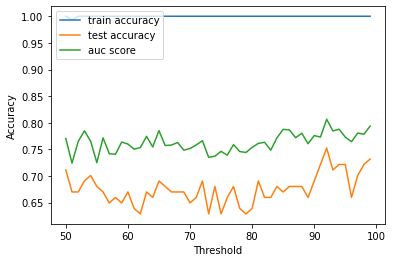

In [42]:
plt.plot(range(50,100,1), train_rslt, label = 'train accuracy')
plt.plot(range(50,100,1), test_rslt, label = 'test accuracy')
plt.plot(range(50,100,1), auc_rslt, label = 'auc score')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

In [43]:
max_auc_idx = auc_rslt.index(max(auc_rslt))
print("We need to remove", 100 - range(50,100)[max_auc_idx],"% of data as outliers in order to optimize our results to get", round(max(auc_rslt),3), "auc score")

We need to remove 8 % of data as outliers in order to optimize our results to get 0.807 auc score


#### Who are the actual outliers?

In [44]:
threshold_train = np.percentile(d_train, range(50,100)[max_auc_idx])
mask_train_mahalanobis = d_train > threshold_train
mask_mcd = ~mask_train_mahalanobis
train_outliers = X_train_labeled_unscaled[mask_train_mahalanobis]
train_inliers = X_train_labeled_unscaled[mask_mcd]
train_outliers.head()

num__ann arbor stage  num__ldh ratio  num__ecog performance status  \
142                   3.0            0.90                           1.0   
129                   2.0            0.78                           2.0   
104                   3.0            1.57                           1.0   
221                   3.0            0.85                           1.0   
203                   3.0           14.84                           2.0   

     num__gender  num__age  num__follow up status alive=0 dead=1  \
142          0.0      52.0                                   1.0   
129          0.0      51.0                                   0.0   
104          0.0      41.0                                   0.0   
221          0.0      78.0                                   1.0   
203          1.0      49.0                                   0.0   

     num__follow up time (yrs)  num__pfs status no progress=0 progress=1  \
142                   2.694045                                       1.0   
129                   7.466119                                       1.0   
104                   8.479124                                       1.0   
221                   4.492813                                       1.0   
203                   7.315537                                       0.0   

     num__pfs (yrs)  __gene expression subgroup__abc  \
142        1.900068                              0.0   
129        0.878850                              1.0   
104        1.546886                              0.0   
221        4.492813                              0.0   
203        7.315537                              0.0   

     __gene expression subgroup__gcb  __gene expression subgroup__unclass  \
142                              1.0                                  0.0   
129                              0.0                                  0.0   
104                              0.0                                  1.0   
221                              1.0                                  0.0   
203                              1.0                                  0.0   

     __biopsy type__pretreatment  __treatment__immunochemotherapy  \
142                          1.0                              1.0   
129                          1.0                              1.0   
104                          1.0                              1.0   
221                          1.0                              1.0   
203                          1.0                              1.0   

     __treatment__unknown  __genetic subtype__bn2  __genetic subtype__ezb  \
142                   0.0                     0.0                     1.0   
129                   0.0                     0.0                     0.0   
104                   0.0                     0.0                     0.0   
221                   0.0                     0.0                     1.0   
203                   0.0                     0.0                     1.0   

     __genetic subtype__mcd  __genetic subtype__other  ipi_values__mean  \
142                     0.0                       0.0               1.0   
129                     0.0                       1.0               1.0   
104                     0.0                       0.0               2.0   
221                     0.0                       0.0               2.0   
203                     0.0                       0.0               3.0   

     ipi_values__min  ipi_values__max  ipi_values__ipi_group  
142              1.0              1.0                    1.0  
129              1.0              1.0                    1.0  
104              2.0              2.0                    2.0  
221              2.0              2.0                    2.0  
203              3.0              3.0                    2.0

In [45]:
pca = PCA(n_components=3)
three_feat_inliers = pca.fit_transform(train_inliers)
in_pca_df = pd.DataFrame(three_feat_inliers, columns = ['component1', 'component2', 'component3'])
three_feat_outliers = pca.fit_transform(train_outliers)
out_pca_df = pd.DataFrame(three_feat_outliers, columns = ['component1', 'component2', 'component3'])

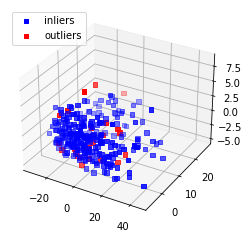

In [46]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(in_pca_df['component1'], in_pca_df['component2'], in_pca_df['component3'], c='b', marker="s", label='inliers')
ax.scatter(out_pca_df['component1'], out_pca_df['component2'],out_pca_df['component3'], c='r', marker="s", label='outliers')
plt.legend(loc='upper left');
plt.show()

### Model 2 - Isolation Forest

The method we used for removing outliers is called <font color='blue'>Isolation Forest</font> (F. T. Liu and K. M. Ting, “Isolation Forest,” 2008,[Link to paper](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest)).

This unsupervised method is similar in principle to Random Forest in a way that it selects a feature and splits by it. Anomalies are identified by having shorter path lengths than other observations (Example is shown below).This method is used widely due to its high-quality, fast anomaly detection and smaller memory requirement.

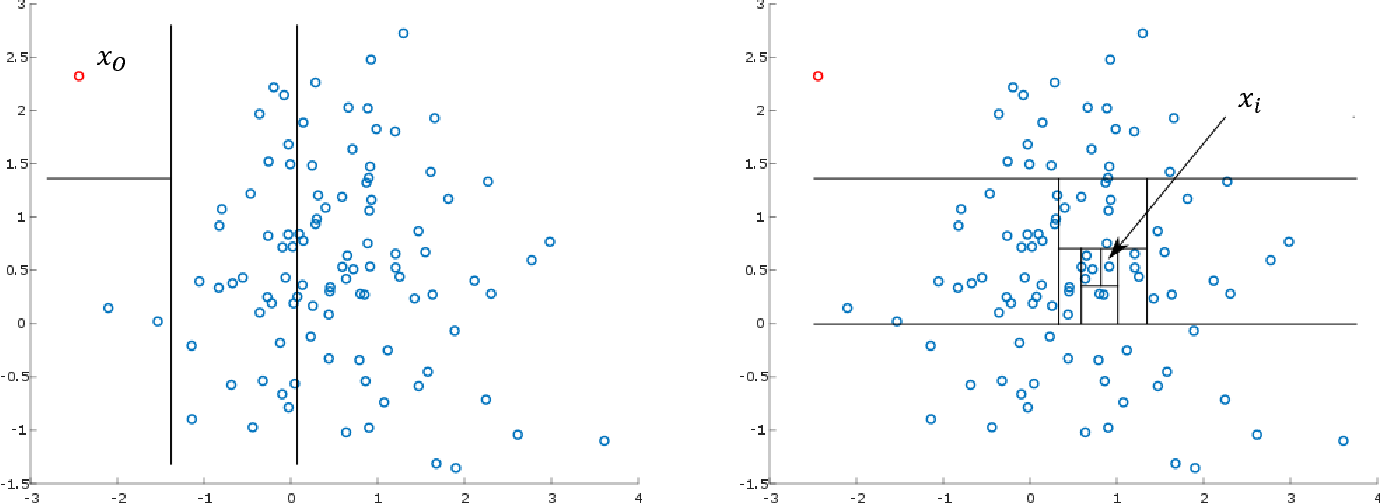

In [47]:
display.Image('https://d3i71xaburhd42.cloudfront.net/c321685dd03fa1a54e99b4c046950b96c3b0f040/3-Figure2-1.png', width = 600)

In [48]:
train_rslt= []
test_rslt= []
auc_rslt = []
IF_ranges_to_test = np.arange(0.01,0.21,0.01)
for c in IF_ranges_to_test:
    iForest = IsolationForest(contamination=c, random_state=random_state_seed)
    iForest.fit(X_train_labeled.values)
    y_outlier = iForest.predict(X_train_labeled.values)
    mask_IF = y_outlier != -1
    #clean outliers from train data
    temp_x_train = X_train_labeled[mask_IF]
    temp_y_train = y_train_labeled[mask_IF]
    #train the model after outliers was moved
    train_accuracy,auc,test_accuracy = estimate_model(clf, temp_x_train.values, temp_y_train, X_test_labeled.values, y_test_labeled)
    train_rslt.append(train_accuracy)
    test_rslt.append(test_accuracy)
    auc_rslt.append(auc)
    

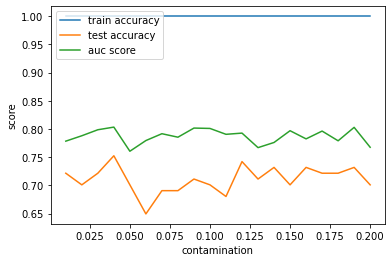

In [49]:
plt.plot(IF_ranges_to_test, train_rslt, label = 'train accuracy')
plt.plot(IF_ranges_to_test, test_rslt, label = 'test accuracy')
plt.plot(IF_ranges_to_test, auc_rslt, label = 'auc score')
plt.xlabel('contamination')
plt.ylabel('score')
plt.legend(loc="upper left")
plt.show()

In [50]:
max_auc_idx = auc_rslt.index(max(auc_rslt))
print("We need to remove", range(1,21)[max_auc_idx] ,"% of data as outliers in order to optimize our results to get", round(max(auc_rslt),3), "auc score")
# print("We need to remove", 100 - range(50,100)[max_auc_idx] ,"% of data as outliers in order to optimize our results to get", round(max(auc_rslt),3), "auc score")

We need to remove 4 % of data as outliers in order to optimize our results to get 0.803 auc score


who are the actual outliers?

In [51]:
c_level = IF_ranges_to_test[max_auc_idx]
iForest = IsolationForest(contamination=c_level, random_state=random_state_seed)
iForest.fit(X_train_labeled)
y_outlier = iForest.predict(X_train_labeled)
mask_IF = y_outlier != -1 #Find the rows that are outliers
X_train_labeled_unscaled[~mask_IF].head()

/Users/linb/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


num__ann arbor stage  num__ldh ratio  num__ecog performance status  \
49                    1.0            0.73                           0.0   
101                   1.0            1.00                           1.0   
8                     4.0            1.49                           2.0   
36                    4.0            2.88                           3.0   
230                   0.0            0.88                           1.0   

     num__gender  num__age  num__follow up status alive=0 dead=1  \
49           1.0      26.0                                   0.0   
101          1.0      54.0                                   0.0   
8            0.0      66.0                                   1.0   
36           0.0      65.0                                   0.0   
230          0.0      71.0                                   1.0   

     num__follow up time (yrs)  num__pfs status no progress=0 progress=1  \
49                   10.401095                                       0.0   
101                  12.279261                                       0.0   
8                     0.867899                                       1.0   
36                    9.273101                                       1.0   
230                   6.291581                                       1.0   

     num__pfs (yrs)  __gene expression subgroup__abc  \
49        10.401095                              1.0   
101       12.279261                              0.0   
8          0.785763                              0.0   
36         2.231348                              0.0   
230        6.291581                              1.0   

     __gene expression subgroup__gcb  __gene expression subgroup__unclass  \
49                               0.0                                  0.0   
101                              1.0                                  0.0   
8                                1.0                                  0.0   
36                               1.0                                  0.0   
230                              0.0                                  0.0   

     __biopsy type__pretreatment  __treatment__immunochemotherapy  \
49                           1.0                              1.0   
101                          1.0                              1.0   
8                            1.0                              1.0   
36                           1.0                              1.0   
230                          1.0                              1.0   

     __treatment__unknown  __genetic subtype__bn2  __genetic subtype__ezb  \
49                    0.0                     0.0                     0.0   
101                   0.0                     0.0                     1.0   
8                     0.0                     1.0                     0.0   
36                    0.0                     0.0                     0.0   
230                   0.0                     0.0                     0.0   

     __genetic subtype__mcd  __genetic subtype__other  ipi_values__mean  \
49                      1.0                       0.0               0.0   
101                     0.0                       0.0               0.0   
8                       0.0                       0.0               5.0   
36                      0.0                       1.0               5.0   
230                     1.0                       0.0               1.5   

     ipi_values__min  ipi_values__max  ipi_values__ipi_group  
49               0.0              0.0                    1.0  
101              0.0              0.0                    1.0  
8                5.0              5.0                    3.0  
36               5.0              5.0                    3.0  
230              1.0              2.0                    1.0

In [52]:
train_outliers = X_train_labeled_unscaled[~mask_IF]
train_inliers = X_train_labeled_unscaled[mask_IF]

In [53]:
pca = PCA(n_components=3)
three_feat_inliers = pca.fit_transform(train_inliers)
in_pca_df = pd.DataFrame(three_feat_inliers, columns = ['component1', 'component2', 'component3'])
three_feat_outliers = pca.fit_transform(train_outliers)
out_pca_df = pd.DataFrame(three_feat_outliers, columns = ['component1', 'component2', 'component3'])

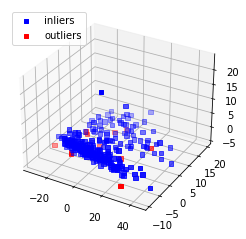

In [54]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(in_pca_df['component1'], in_pca_df['component2'], in_pca_df['component3'], c='b', marker="s", label='inliers')
ax.scatter(out_pca_df['component1'], out_pca_df['component2'],out_pca_df['component3'], c='r', marker="s", label='outliers')
plt.legend(loc='upper left');
plt.show()

### Model 3 - DBSCAN

Density-based spatial clustering of applications with noise (DBSCAN) is a data clustering algorithm proposed by Martin Ester, Hans-Peter Kriegel, Jörg Sander and Xiaowei Xu in 1996. It is a density-based clustering non-parametric algorithm: given a set of points in some space, it groups together points that are closely packed together. It's hyperparameters are: epsilon, which determines how close two observations needs to be in order to belong to the same cluster, and min points, which determinese the minimal number of close observations that defines a cluster.

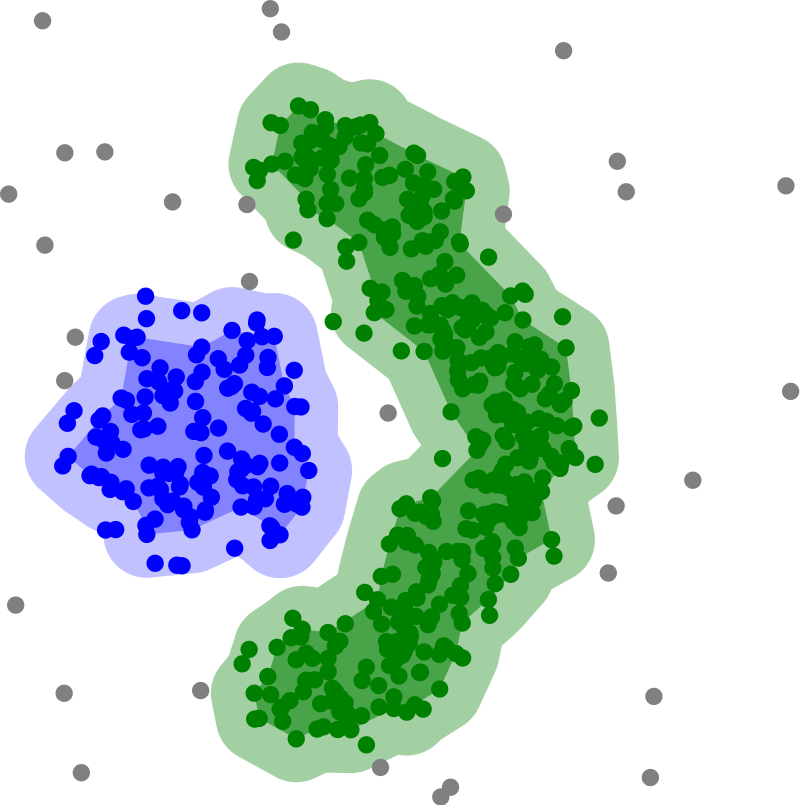

In [55]:
display.Image('800px-DBSCAN-density-data.png', width = 400)

In [56]:
dbscan_aucs = {}

for e in range(1,14):
    for min_samp in range(2,4):
        clustering = DBSCAN(eps=e, min_samples=min_samp).fit(X_train_labeled)
        clustering.labels_
        inlier_idx = clustering.labels_!=-1
        temp_x_train = X_train_labeled[inlier_idx]
        temp_y_train = y_train_labeled[inlier_idx]
        train_accuracy,auc,test_accuracy = estimate_model(clf, temp_x_train, temp_y_train, X_test_labeled, y_test_labeled)
        dbscan_aucs[(e, min_samp)] = auc

In [57]:
max_key2 = max(dbscan_aucs, key=dbscan_aucs.get)
print("The best parameters for dbscan are epsilon =",max_key2[0],"& min_samples=",max_key2[1]," which give us auc score of ", dbscan_aucs[max_key2])

The best parameters for dbscan are epsilon = 1 & min_samples= 2  which give us auc score of  0.7848936170212765


In [58]:
clustering = DBSCAN(eps=max_key2[0], min_samples=max_key2[1]).fit(X_train_labeled)
clustering.labels_
mask_dbscan = clustering.labels_!=-1 # All the inliers are the ones that received cluster != 1
temp_x_train = X_train_labeled[mask_dbscan]
temp_y_train = y_train_labeled[mask_dbscan]
train_accuracy,auc,test_accuracy = estimate_model(clf, temp_x_train, temp_y_train, X_test_labeled, y_test_labeled)
print("train accuracy:", train_accuracy, "auc:", auc,"test_accuracy",test_accuracy)

train accuracy: 1.0 auc: 0.7848936170212765 test_accuracy 0.7319587628865979


who are the actual outliers?

In [59]:
X_train_labeled_unscaled[~mask_dbscan]

num__ann arbor stage  num__ldh ratio  num__ecog performance status  \
129                   2.0            0.78                           2.0   
104                   3.0            1.57                           1.0   
303                   4.0            0.92                           3.0   
198                   4.0            1.12                           1.0   
77                    2.0            0.68                           1.0   
8                     4.0            1.49                           2.0   
36                    4.0            2.88                           3.0   
511                   3.0            1.12                           1.0   
185                   4.0            5.56                           3.0   
60                    4.0            1.64                           2.0   
51                    3.0            1.23                           2.0   
122                   2.0            0.72                           1.0   
33                    2.0            0.60                           2.0   
160                   2.0            1.29                           2.0   
86                    3.0            1.88                           3.0   
135                   4.0            0.47                           1.0   
28                    4.0            1.12                           0.0   
212                   4.0            7.06                           3.0   
174                   1.0            0.70                           0.0   
70                    3.0            1.53                           1.0   
571                   4.0            0.00                           0.0   
96                    2.0            0.90                           3.0   
23                    1.0            0.72                           0.0   
380                   3.0            1.24                           3.0   
171                   3.0            1.12                           1.0   
205                   4.0            1.12                           3.0   
487                   1.0            0.72                           1.0   
39                    4.0           30.76                           1.0   
565                   4.0            1.12                           5.0   
170                   2.0            2.00                           0.0   
128                   2.0            1.95                           1.0   
125                   1.0            1.20                           1.0   

     num__gender  num__age  num__follow up status alive=0 dead=1  \
129          0.0      51.0                                   0.0   
104          0.0      41.0                                   0.0   
303          0.0      67.0                                   0.0   
198          1.0      54.0                                   1.0   
77           1.0      54.0                                   1.0   
8            0.0      66.0                                   1.0   
36           0.0      65.0                                   0.0   
511          1.0      62.0                                   0.0   
185          1.0      64.0                                   1.0   
60           1.0      74.0                                   1.0   
51           1.0      86.0                                   0.0   
122          1.0      62.0                                   0.0   
33           0.0      42.0                                   0.0   
160          0.0      59.0                                   0.0   
86           1.0      68.0                                   1.0   
135          0.0      58.0                                   0.0   
28           0.0      46.0                                   1.0   
212          0.0      48.0                                   1.0   
174          0.0      42.0                                   0.0   
70           0.0      61.0                                   0.0   
571          1.0      56.0                                   0.0   
96           0.0      73.0       

In [60]:
print("We need to remove", round((len(X_train_labeled_unscaled[~mask_dbscan])/len(X_train_labeled))*100, 3) ,"% of data as outliers in order to optimize our results to get", round(dbscan_aucs[max_key2],3), "auc score")

We need to remove 11.034 % of data as outliers in order to optimize our results to get 0.785 auc score


In [61]:
train_outliers = X_train_labeled_unscaled[~mask_dbscan]
train_inliers = X_train_labeled_unscaled[mask_dbscan]

In [62]:
pca = PCA(n_components=3)
three_feat_inliers = pca.fit_transform(train_inliers)
in_pca_df = pd.DataFrame(three_feat_inliers, columns = ['component1', 'component2', 'component3'])
three_feat_outliers = pca.fit_transform(train_outliers)
out_pca_df = pd.DataFrame(three_feat_outliers, columns = ['component1', 'component2', 'component3'])

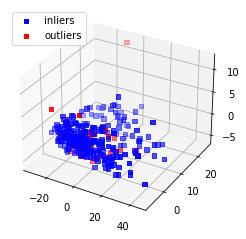

In [63]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(in_pca_df['component1'], in_pca_df['component2'], in_pca_df['component3'], c='b', marker="s", label='inliers')
ax.scatter(out_pca_df['component1'], out_pca_df['component2'],out_pca_df['component3'], c='r', marker="s", label='outliers')
plt.legend(loc='upper left');
plt.show()

## Model Selection

## Baseline model
We'll develop a simple rule-based algorithm as a baseline using a Decision Tree with just the top 5 features in the RF feature importance (For simplicity purposes).

We will use this baseline to compare the performance of our more-complex models

Best parameters are: {'criterion': 'gini', 'max_depth': 3}
AVG Train AUC: 0.807


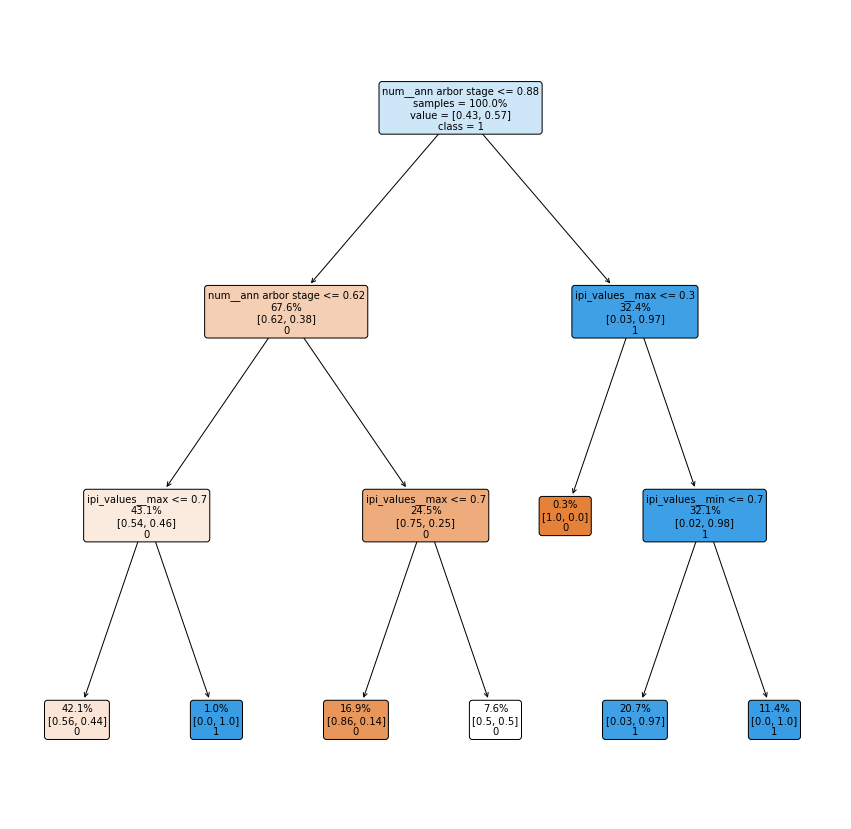

Validation AUC: 0.752
Validation Accuracy: 0.742


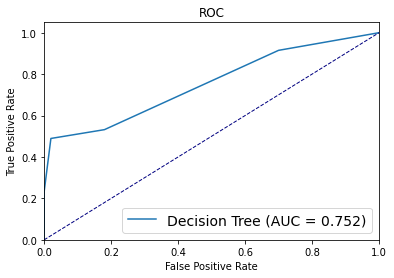

/Users/linb/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


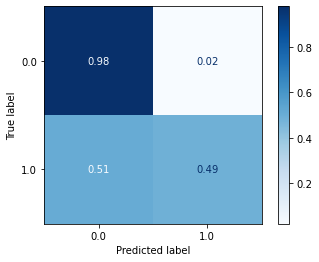

In [64]:
classifier = DecisionTreeClassifier
params = {'max_depth':[3], 'criterion':['gini','entropy']}
clf_model = GridSearchCV(classifier(), param_grid=params, scoring = 'roc_auc', cv=5,n_jobs=-1)
clf_model.fit(X_train_labeled[top_5_feat], y_train_labeled.values.ravel())

# Run the model with the best parameters
best_params = clf_model.best_params_
print('Best parameters are: {}'.format(best_params))
print('AVG Train AUC: {:.3f}'.format(clf_model.best_score_))                     

model_for_pred = classifier(**best_params)

model_for_pred.fit(X_train_labeled[top_5_feat],y_train_labeled.values.ravel())


fig, ax = plt.subplots(figsize=(15, 15))
tree.plot_tree(model_for_pred,rounded=True,filled=True,precision=2,proportion= True,label='root',class_names=['0','1'],impurity=False,feature_names=X_train_labeled[top_5_feat].columns, fontsize=10)
plt.show()



y_pred = model_for_pred.predict_proba(X_test_labeled[top_5_feat])[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test_labeled, y_pred, pos_label=1)
auc = metrics.auc(fpr,tpr)
accuracy_score = metrics.accuracy_score(y_test_labeled, np.round(y_pred))
print('Validation AUC: {:.3f}'.format(auc))                     
print('Validation Accuracy: {:.3f}'.format(accuracy_score))
#----- Plots -----

# Plot ROC
lw=1
plt.figure()
plt.plot(fpr,tpr,label='Decision Tree (AUC = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right",fontsize=14)
plt.show()

# Plot Confusion Matrix
metrics.plot_confusion_matrix(model_for_pred,X_test_labeled[top_5_feat],y_test_labeled,cmap=plt.cm.Blues, normalize='true')



## Prediction

<font color='royalblue'>**A(3.1) + A(3.2)**</font> 


We will examine 4 models:
- Logistic Regression
- KNN
- Random Forest
- Multi-layer Perceptron (NN)

Process:
1. We will run each model twice - once with the subset of features selected in 5.1, and once with all features
2. Maximizing AUC is the main metric -> parameters are chosen to maximize AUC 
3. Parameters for each classifier are chosen using gridsearch on 5-folds of the training data
4. Then, we run each classifier with the chosen parameters on the validation data (an unseen subset of the data given during training)
5. The classifier with the best results on the "test" is chosen for the final prediction

In [65]:
# Model configurations
model_clf = {'Logistic Regression': LogisticRegression,
             'KNN': KNeighborsClassifier,
             'Random Forest': RandomForestClassifier,
             'MLPClassifier': MLPClassifier,
                }
outlier_removal_method_dict = {'Full df (without removing any records)':np.ones(mask_mcd.shape)==1,'MCD':mask_mcd,'Isolation Forest':mask_IF,'DBSCAN':mask_dbscan}# for key,val in outlier_removal_method_dict.items():
#     print(key,val)
# Parameters for each classifier
param_dist = {
                'Logistic Regression':
                {
#                     'C': [0.01, 0.1, 1, 100, 1000], #Inverse regularization parameter, large C means less regularization.
                    'C': [1, 100,1000], # We have examined a larget range of Cs, but to save runtime we will explore these 3 which produced better results
                    'penalty': ['l1','l2'], # the norm used in the penalization
                    'max_iter': [100], # Maximum number of iterations taken for the solvers to converge
                    'solver': ["liblinear"], # Algorithm to use in the optimization problem, 'liblinear' performs better on smaller datasets
                    'random_state': [random_state_seed]
                },
                
                'KNN':
                {
                    'n_neighbors': [3,5,7,9],  # Number of neighbors. We specifically choose odd numbers so there would always be a tie-breaker
#                     'weights': ['uniform', 'distance'], #weight function used in prediction. In ‘uniform’ - All points in each neighborhood are weighted equally. In ‘distance’ - weight points by the inverse of their distance.
                    # To save runtime, we chose for the final run a minimal number of parameters:
#                     'n_neighbors': [7,9], 
                    'weights': ['distance'], #To save runtime - we only choose the 'distance' function as it produced better results on our training set 
         
                },
    
                'Random Forest': 
                {
                    'n_estimators':[51,101,151], # The number of trees in the forest
                    'min_samples_split':[2,3,4],     # The minimum number of samples required to split an internal node
#                     'max_depth':[12,25,None],    # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                    'max_depth':[25,None],    # To Save final runtime, we chose these values which produced the best results
                    'max_features':["auto",None], # The number of features to consider when looking for the best split
                    'bootstrap':[True],           # Whether bootstrap samples are used when building trees
                    'random_state': [random_state_seed]
                },
                 'MLPClassifier': 
                {
                    'hidden_layer_sizes':[(len(all_features),),(len(permutation_importance_features),20,10)], # The number of neuorons in each layer
                    'activation':['logistic','relu'],                   # Activation function of the hidden layer
                    'max_iter':[120] ,                                   # Maximum number of iterations
                    'random_state': [random_state_seed]
                    # Optimization on the training data does not converge at this maximum number of iterations, but we chose this to save runtime.
                    # 'max_iter':[100,120,150,200]
                 },
            }

*******************************************
outlier method: Full df (without removing any records)
Classifier name: Logistic Regression
num_of_features: 15
Best parameters are: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'random_state': 711, 'solver': 'liblinear'}
AVG Train AUC: 0.666
Test AUC: 0.695
Test Accuracy: 0.619


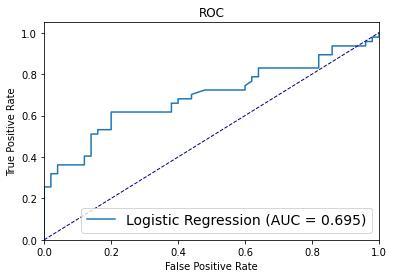

*******************************************
outlier method: Full df (without removing any records)
Classifier name: Logistic Regression
num_of_features: 23
Best parameters are: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'random_state': 711, 'solver': 'liblinear'}
AVG Train AUC: 0.693
Test AUC: 0.685
Test Accuracy: 0.639


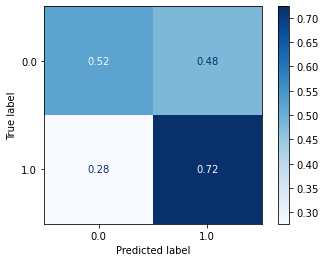

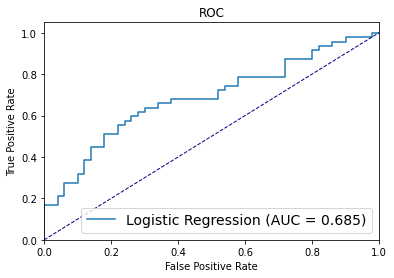

*******************************************
outlier method: Full df (without removing any records)
Classifier name: KNN
num_of_features: 15
Best parameters are: {'n_neighbors': 9, 'weights': 'distance'}
AVG Train AUC: 0.567
Test AUC: 0.627
Test Accuracy: 0.577


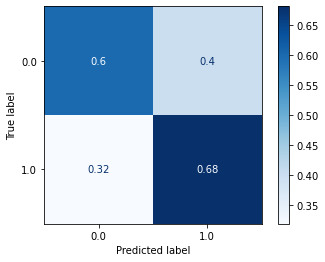

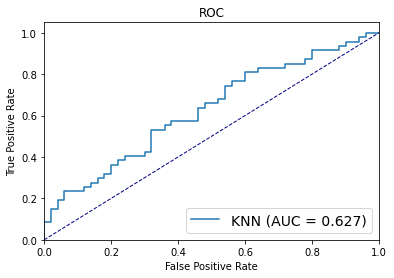

*******************************************
outlier method: Full df (without removing any records)
Classifier name: KNN
num_of_features: 23
Best parameters are: {'n_neighbors': 7, 'weights': 'distance'}
AVG Train AUC: 0.566
Test AUC: 0.625
Test Accuracy: 0.577


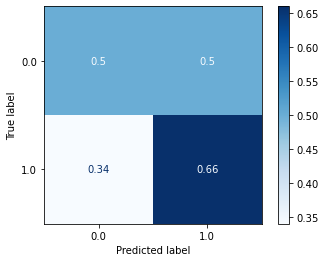

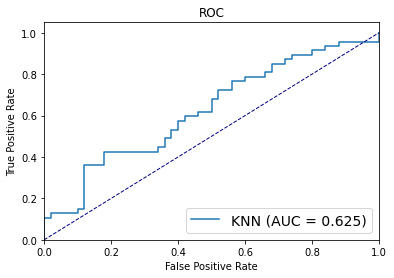

*******************************************
outlier method: Full df (without removing any records)
Classifier name: Random Forest
num_of_features: 15
Best parameters are: {'bootstrap': True, 'max_depth': 25, 'max_features': None, 'min_samples_split': 4, 'n_estimators': 151, 'random_state': 711}
AVG Train AUC: 0.800
Test AUC: 0.806
Test Accuracy: 0.701


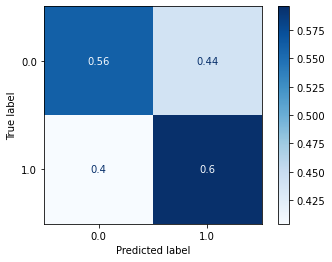

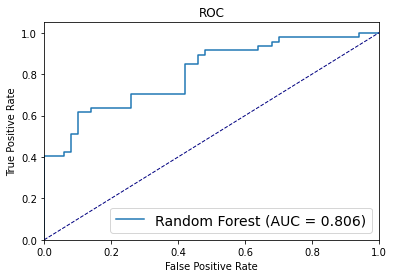

*******************************************
outlier method: Full df (without removing any records)
Classifier name: Random Forest
num_of_features: 23
Best parameters are: {'bootstrap': True, 'max_depth': 25, 'max_features': None, 'min_samples_split': 4, 'n_estimators': 151, 'random_state': 711}
AVG Train AUC: 0.786
Test AUC: 0.806
Test Accuracy: 0.701


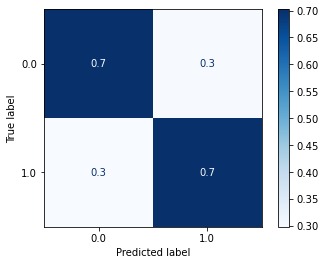

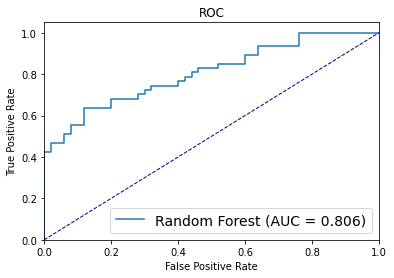

*******************************************
outlier method: Full df (without removing any records)
Classifier name: MLPClassifier
num_of_features: 15
Best parameters are: {'activation': 'logistic', 'hidden_layer_sizes': (15, 20, 10), 'max_iter': 120, 'random_state': 711}
AVG Train AUC: 0.631
Test AUC: 0.660
Test Accuracy: 0.485


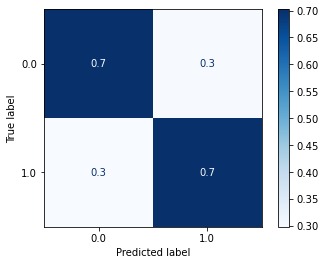

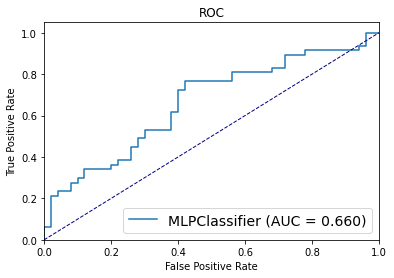

*******************************************
outlier method: Full df (without removing any records)
Classifier name: MLPClassifier
num_of_features: 23
Best parameters are: {'activation': 'relu', 'hidden_layer_sizes': (23,), 'max_iter': 120, 'random_state': 711}
AVG Train AUC: 0.648
Test AUC: 0.722
Test Accuracy: 0.649


/Users/linb/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/linb/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(


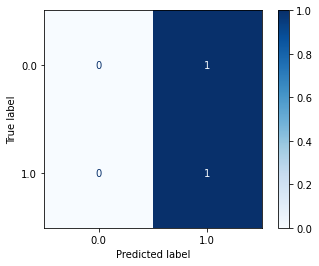

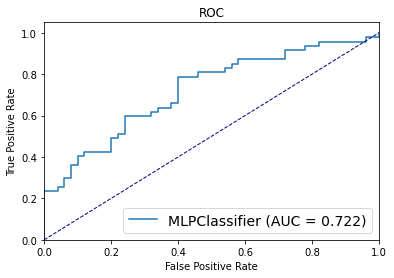

*******************************************
outlier method: MCD
Classifier name: Logistic Regression
num_of_features: 15
Best parameters are: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'random_state': 711, 'solver': 'liblinear'}
AVG Train AUC: 0.646
Test AUC: 0.688
Test Accuracy: 0.588


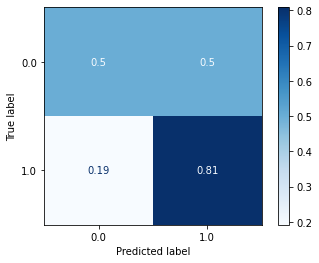

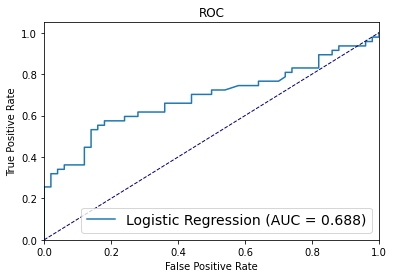

*******************************************
outlier method: MCD
Classifier name: Logistic Regression
num_of_features: 23
Best parameters are: {'C': 100, 'max_iter': 100, 'penalty': 'l1', 'random_state': 711, 'solver': 'liblinear'}
AVG Train AUC: 0.665
Test AUC: 0.693
Test Accuracy: 0.629


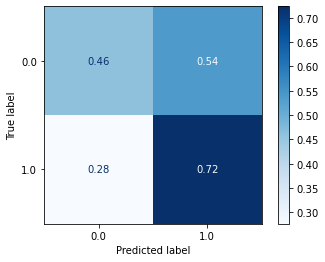

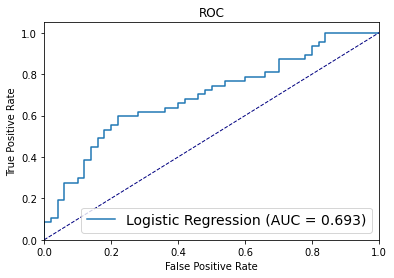

*******************************************
outlier method: MCD
Classifier name: KNN
num_of_features: 15
Best parameters are: {'n_neighbors': 9, 'weights': 'distance'}
AVG Train AUC: 0.537
Test AUC: 0.607
Test Accuracy: 0.536


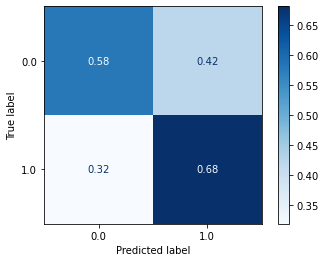

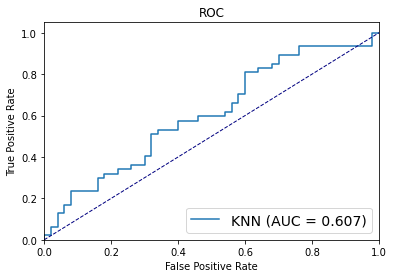

*******************************************
outlier method: MCD
Classifier name: KNN
num_of_features: 23
Best parameters are: {'n_neighbors': 9, 'weights': 'distance'}
AVG Train AUC: 0.528
Test AUC: 0.623
Test Accuracy: 0.546


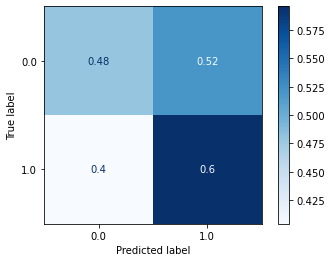

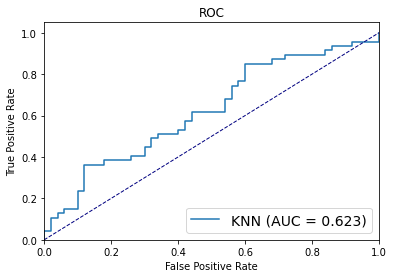

*******************************************
outlier method: MCD
Classifier name: Random Forest
num_of_features: 15
Best parameters are: {'bootstrap': True, 'max_depth': 25, 'max_features': None, 'min_samples_split': 4, 'n_estimators': 51, 'random_state': 711}
AVG Train AUC: 0.776
Test AUC: 0.824
Test Accuracy: 0.691


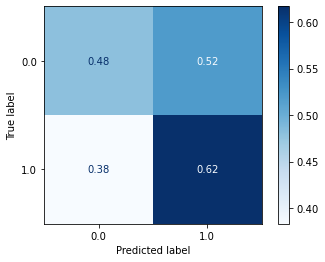

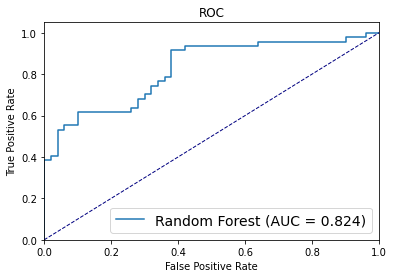

*******************************************
outlier method: MCD
Classifier name: Random Forest
num_of_features: 23
Best parameters are: {'bootstrap': True, 'max_depth': 25, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 151, 'random_state': 711}
AVG Train AUC: 0.762
Test AUC: 0.809
Test Accuracy: 0.732


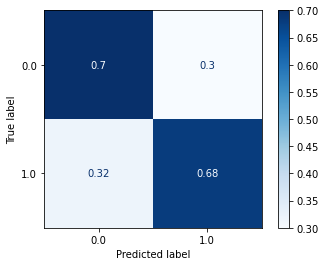

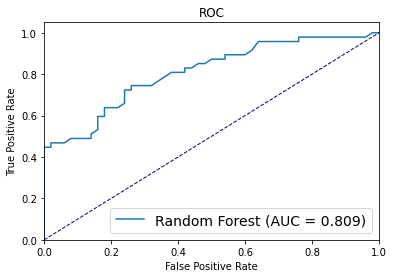

*******************************************
outlier method: MCD
Classifier name: MLPClassifier
num_of_features: 15
Best parameters are: {'activation': 'logistic', 'hidden_layer_sizes': (15, 20, 10), 'max_iter': 120, 'random_state': 711}
AVG Train AUC: 0.639
Test AUC: 0.636
Test Accuracy: 0.485


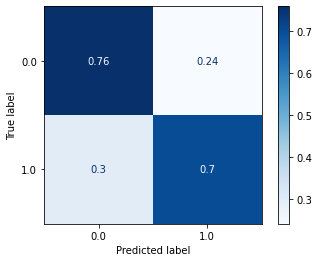

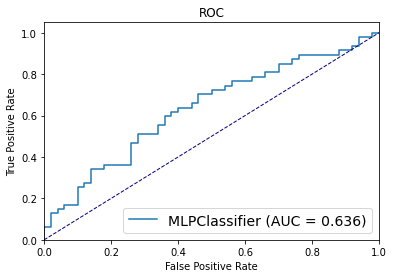

*******************************************
outlier method: MCD
Classifier name: MLPClassifier
num_of_features: 23
Best parameters are: {'activation': 'logistic', 'hidden_layer_sizes': (23,), 'max_iter': 120, 'random_state': 711}
AVG Train AUC: 0.621
Test AUC: 0.708
Test Accuracy: 0.505


/Users/linb/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/linb/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(


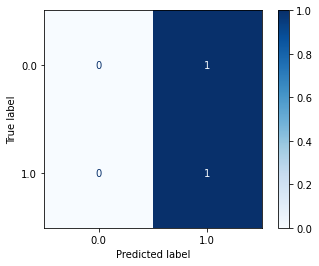

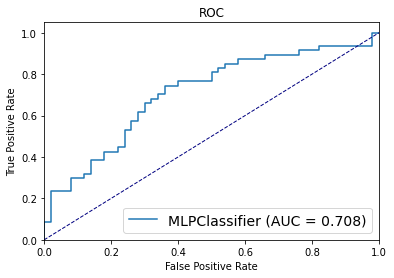

*******************************************
outlier method: Isolation Forest
Classifier name: Logistic Regression
num_of_features: 15
Best parameters are: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'random_state': 711, 'solver': 'liblinear'}
AVG Train AUC: 0.664
Test AUC: 0.688
Test Accuracy: 0.588


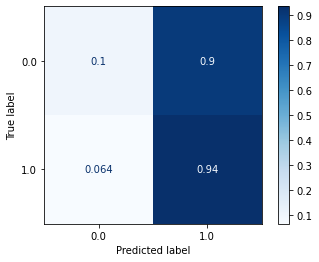

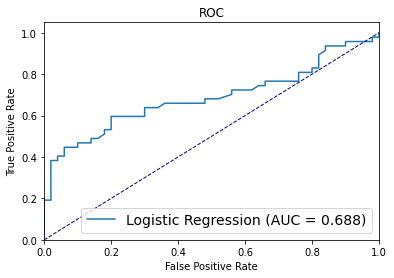

*******************************************
outlier method: Isolation Forest
Classifier name: Logistic Regression
num_of_features: 23
Best parameters are: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'random_state': 711, 'solver': 'liblinear'}
AVG Train AUC: 0.682
Test AUC: 0.687
Test Accuracy: 0.588


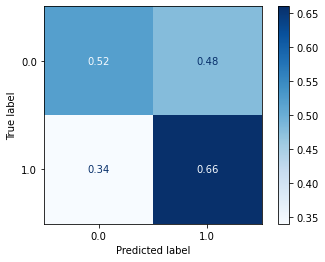

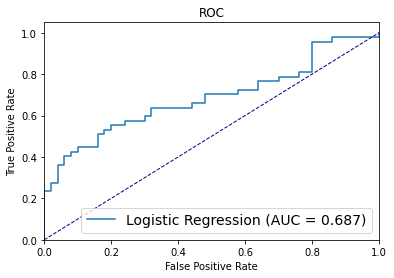

*******************************************
outlier method: Isolation Forest
Classifier name: KNN
num_of_features: 15
Best parameters are: {'n_neighbors': 9, 'weights': 'distance'}
AVG Train AUC: 0.543
Test AUC: 0.620
Test Accuracy: 0.577


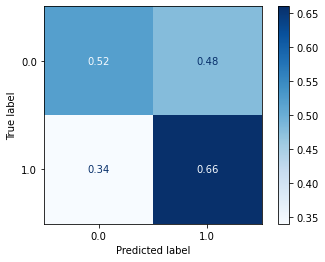

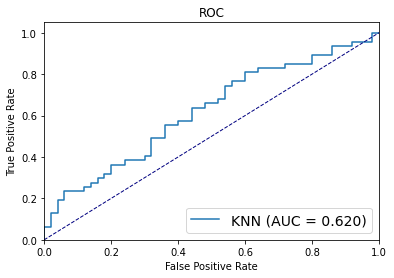

*******************************************
outlier method: Isolation Forest
Classifier name: KNN
num_of_features: 23
Best parameters are: {'n_neighbors': 9, 'weights': 'distance'}
AVG Train AUC: 0.531
Test AUC: 0.617
Test Accuracy: 0.557


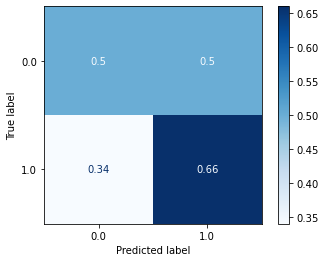

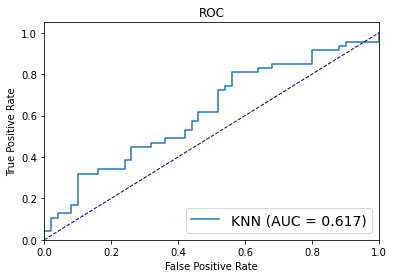

*******************************************
outlier method: Isolation Forest
Classifier name: Random Forest
num_of_features: 15
Best parameters are: {'bootstrap': True, 'max_depth': 25, 'max_features': None, 'min_samples_split': 4, 'n_estimators': 151, 'random_state': 711}
AVG Train AUC: 0.794
Test AUC: 0.809
Test Accuracy: 0.711


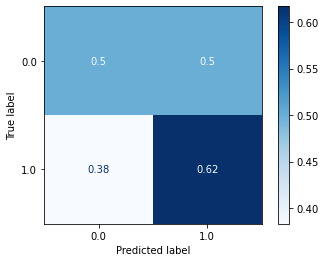

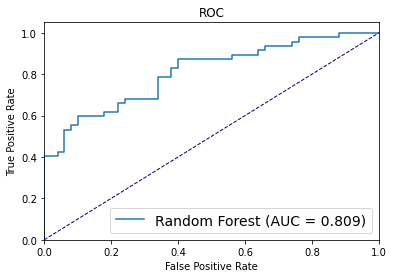

*******************************************
outlier method: Isolation Forest
Classifier name: Random Forest
num_of_features: 23
Best parameters are: {'bootstrap': True, 'max_depth': 25, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 151, 'random_state': 711}
AVG Train AUC: 0.786
Test AUC: 0.806
Test Accuracy: 0.722


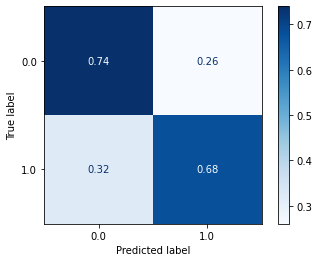

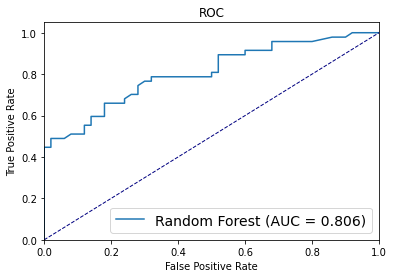

*******************************************
outlier method: Isolation Forest
Classifier name: MLPClassifier
num_of_features: 15
Best parameters are: {'activation': 'logistic', 'hidden_layer_sizes': (15, 20, 10), 'max_iter': 120, 'random_state': 711}
AVG Train AUC: 0.631
Test AUC: 0.653
Test Accuracy: 0.485


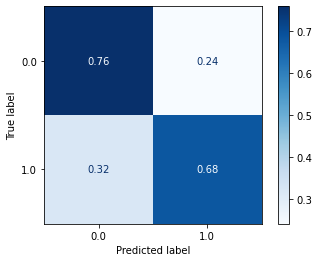

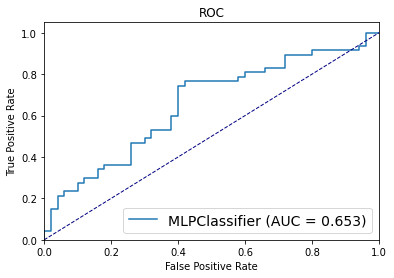

*******************************************
outlier method: Isolation Forest
Classifier name: MLPClassifier
num_of_features: 23
Best parameters are: {'activation': 'logistic', 'hidden_layer_sizes': (15, 20, 10), 'max_iter': 120, 'random_state': 711}
AVG Train AUC: 0.622
Test AUC: 0.608
Test Accuracy: 0.485


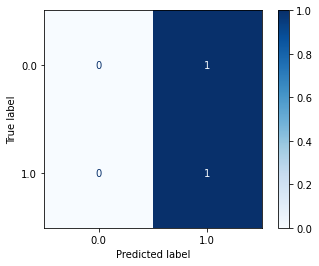

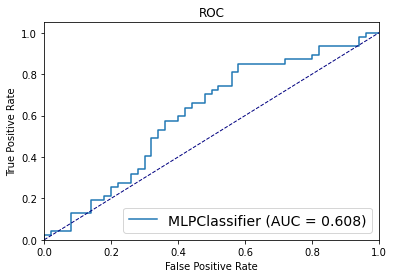

*******************************************
outlier method: DBSCAN
Classifier name: Logistic Regression
num_of_features: 15
Best parameters are: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'random_state': 711, 'solver': 'liblinear'}
AVG Train AUC: 0.667
Test AUC: 0.699
Test Accuracy: 0.619


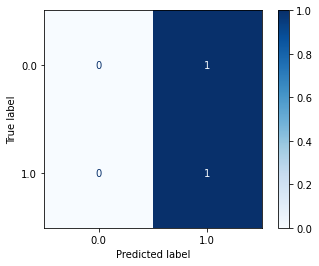

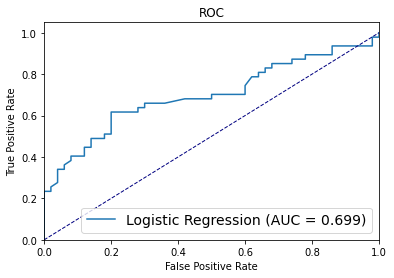

*******************************************
outlier method: DBSCAN
Classifier name: Logistic Regression
num_of_features: 23
Best parameters are: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'random_state': 711, 'solver': 'liblinear'}
AVG Train AUC: 0.687
Test AUC: 0.691
Test Accuracy: 0.619


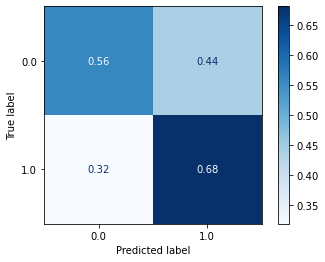

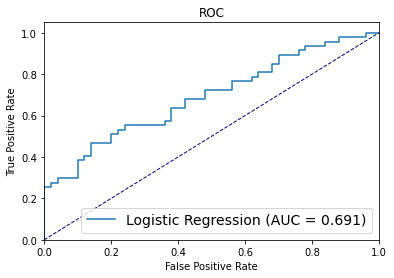

*******************************************
outlier method: DBSCAN
Classifier name: KNN
num_of_features: 15
Best parameters are: {'n_neighbors': 9, 'weights': 'distance'}
AVG Train AUC: 0.559
Test AUC: 0.634
Test Accuracy: 0.588


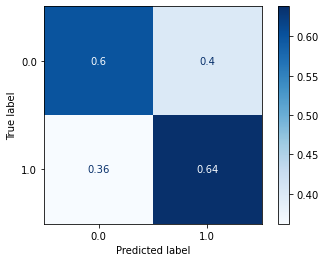

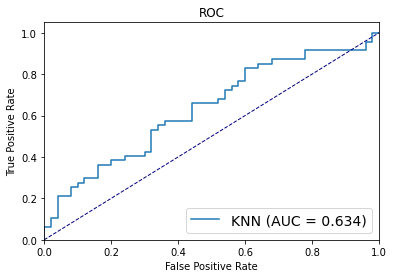

*******************************************
outlier method: DBSCAN
Classifier name: KNN
num_of_features: 23
Best parameters are: {'n_neighbors': 9, 'weights': 'distance'}
AVG Train AUC: 0.549
Test AUC: 0.625
Test Accuracy: 0.598


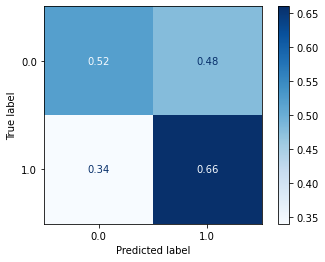

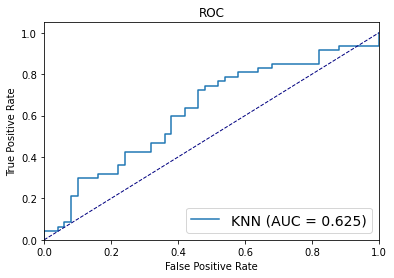

*******************************************
outlier method: DBSCAN
Classifier name: Random Forest
num_of_features: 15
Best parameters are: {'bootstrap': True, 'max_depth': 25, 'max_features': None, 'min_samples_split': 4, 'n_estimators': 151, 'random_state': 711}
AVG Train AUC: 0.799
Test AUC: 0.793
Test Accuracy: 0.670


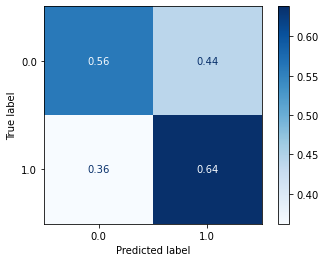

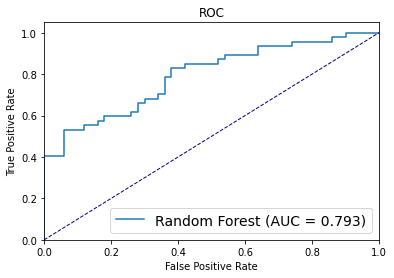

*******************************************
outlier method: DBSCAN
Classifier name: Random Forest
num_of_features: 23
Best parameters are: {'bootstrap': True, 'max_depth': 25, 'max_features': None, 'min_samples_split': 4, 'n_estimators': 151, 'random_state': 711}
AVG Train AUC: 0.788
Test AUC: 0.813
Test Accuracy: 0.649


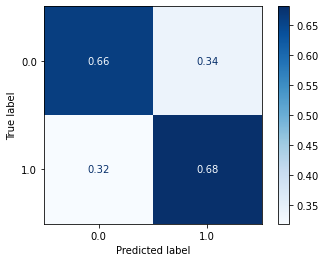

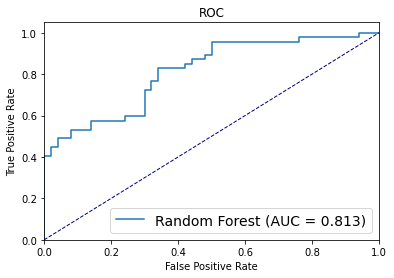

*******************************************
outlier method: DBSCAN
Classifier name: MLPClassifier
num_of_features: 15
Best parameters are: {'activation': 'logistic', 'hidden_layer_sizes': (15, 20, 10), 'max_iter': 120, 'random_state': 711}
AVG Train AUC: 0.633
Test AUC: 0.666
Test Accuracy: 0.485


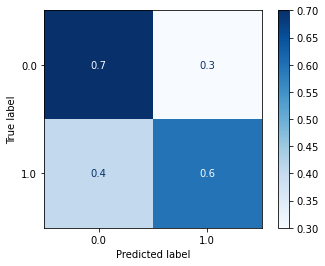

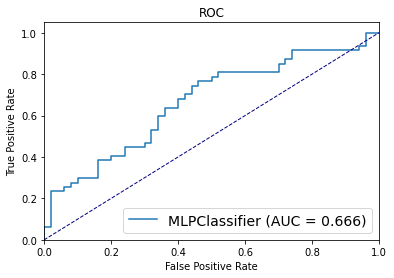

*******************************************
outlier method: DBSCAN
Classifier name: MLPClassifier
num_of_features: 23
Best parameters are: {'activation': 'relu', 'hidden_layer_sizes': (23,), 'max_iter': 120, 'random_state': 711}
AVG Train AUC: 0.638
Test AUC: 0.720
Test Accuracy: 0.639


/Users/linb/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/linb/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(


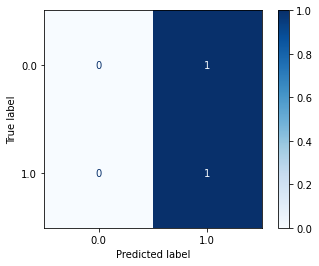

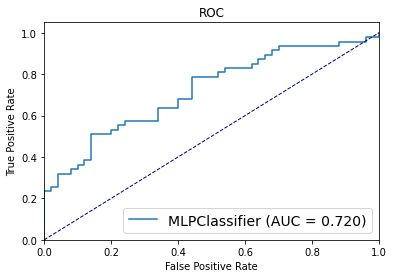

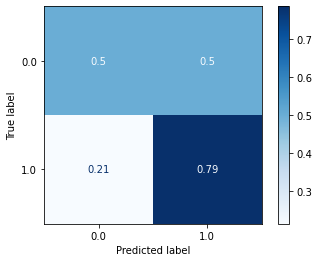

In [66]:
# -- Long runtime --
best_params_per_model = {}
y_pred_dict_per_model = {} # Saving the prediction of each model so we could show all ROC curves in one plot
best_params_dct = {}
aucs = {}
aucs_with_outliers = {}
for outlier_detection_method in outlier_removal_method_dict:
    for classifier_name in model_clf:
        for feat_group in (permutation_importance_features,all_features):
            print('*******************************************')
            print('outlier method:', outlier_detection_method)
            print ('Classifier name:', classifier_name)
            print ('num_of_features:',len(feat_group))

            classifier = model_clf[classifier_name]
            params = param_dist[classifier_name]
            inlier_mask = outlier_removal_method_dict[outlier_detection_method]
            clf_model = GridSearchCV(classifier(), param_grid=params, scoring = 'roc_auc',n_jobs=-1)
            clf_model.fit(X_train_labeled.loc[inlier_mask,feat_group], y_train_labeled[inlier_mask].values.ravel())

            # Run the model with the best parameters
            best_params = clf_model.best_params_
            print('Best parameters are: {}'.format(best_params))
            print('AVG Train AUC: {:.3f}'.format(clf_model.best_score_))  
            best_params_dct[classifier_name] = best_params

            model_for_pred = classifier(**best_params)

            model_for_pred.fit(X_train_labeled.loc[inlier_mask,feat_group],y_train_labeled[inlier_mask].values.ravel())
            y_pred = model_for_pred.predict_proba(X_test_labeled[feat_group])[:,1]

            y_pred_dict_per_model[(classifier_name,outlier_detection_method,len(feat_group))] = y_pred


            fpr, tpr, thresholds = metrics.roc_curve(y_test_labeled, y_pred, pos_label=1)
            auc = metrics.auc(fpr,tpr)
            if outlier_detection_method == 'Full df (without removing any records)':
                aucs_with_outliers[(classifier_name, len(feat_group))] = auc
            else:
                aucs[(classifier_name,outlier_detection_method, len(feat_group))] = auc
            accuracy_score = metrics.accuracy_score(y_test_labeled, np.round(y_pred))
            print('Test AUC: {:.3f}'.format(auc))                     
            print('Test Accuracy: {:.3f}'.format(accuracy_score))
            best_params_per_model[(classifier_name,outlier_detection_method,len(feat_group))] = best_params
            

            #----- Plots -----
            # Plot ROC
            lw=1
            plt.figure()
            plt.plot(fpr,tpr,label='{} (AUC = {:.3f})'.format(classifier_name,auc))
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC')
            plt.legend(loc="lower right",fontsize=14)
            plt.show()

            # Plot Confusion Matrix
            metrics.ConfusionMatrixDisplay.from_estimator(model_for_pred,X_test_labeled[feat_group],y_test_labeled,cmap=plt.cm.Blues, normalize='true')

            plt.grid(False)

## Best model with outliers

In [67]:
max_key1 = max(aucs_with_outliers, key=aucs_with_outliers.get)
print("The best classifier with outliers is", max_key1[0],"with", max_key1[1], "features which give us auc score of", aucs_with_outliers[max_key1])

The best classifier with outliers is Random Forest with 15 features which give us auc score of 0.8063829787234043


## Best model after outlier removal

In [68]:
max_key2 = max(aucs, key=aucs.get)
print("The combination of classifier and anomaly detection method is", max_key2[0],"&",max_key2[1],"and", max_key2[2], "features which give us auc score of:", aucs[max_key2])

The combination of classifier and anomaly detection method is Random Forest & MCD and 15 features which give us auc score of: 0.8238297872340425


### Outlier Model Proficiency

In [69]:
aucs[max_key2] - aucs_with_outliers[max_key1]

0.01744680851063829

## Labelling the unlabeled datapoints (Semi-supervision)

Pseudocode:

    1) Train RF classifier on the labeled training data.
    2) Use the classifier to predict labels for all unlabeled data.
    3) Concatenante the pseudo-labeled data with the labeled training data.
    4) Use trained classifier to make predictions for the labeled test data.

In [70]:
classifier_name = 'Random Forest'
outlier_detection_method = 'MCD'
feat_group = permutation_importance_features

In [71]:
X_train = X_train_labeled.loc[mask_mcd,feat_group].copy()
y_train = y_train_labeled[mask_mcd].copy()
X_test = X_test_labeled[feat_group].copy()
y_test = y_test_labeled.copy()
X_unlabeled = X_unlabled[feat_group].copy()

In [72]:
from sklearn.metrics import f1_score

high_prob_tagging = 0.75
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0 and X_unlabeled.shape[0]>0 :
    # Fit classifier and make train/test predictions
#     clf = LogisticRegression(max_iter=1000)
    clf = RandomForestClassifier(**best_params_dct['Random Forest'])
    clf.fit(X_train, y_train)
    y_hat_train = clf.predict(X_train)
    y_hat_test = clf.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1 = f1_score(y_train, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
   
    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > high_prob_tagging probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > high_prob_tagging],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > high_prob_tagging]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1

Iteration 0
Train f1: 0.9807692307692307
Test f1: 0.6938775510204082
Now predicting labels for unlabeled data...
79 high-probability predictions added to training data.
50 unlabeled instances remaining.

Iteration 1
Train f1: 0.9848156182212582
Test f1: 0.7070707070707072
Now predicting labels for unlabeled data...
22 high-probability predictions added to training data.
28 unlabeled instances remaining.

Iteration 2
Train f1: 0.9881422924901185
Test f1: 0.68
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
26 unlabeled instances remaining.

Iteration 3
Train f1: 0.988235294117647
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
26 unlabeled instances remaining.



*******************************************
outlier method: MCD
Classifier name: Random Forest
num_of_features: 15
Best parameters are: {'bootstrap': True, 'max_depth': 25, 'max_features': None, 'min_samples_split': 4, 'n_estimators': 101, 'random_state': 711}
AVG Train AUC: 0.873
Test AUC: 0.801
Test Accuracy: 0.670


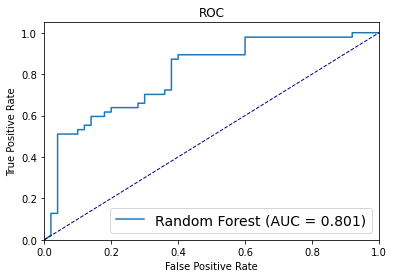

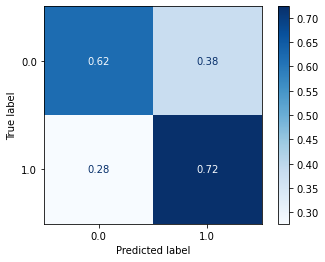

In [73]:
classifier_name = 'Random Forest'
# outlier_detection_method = 'MCD'
# feat_group = all_features

print('*******************************************')
print('outlier method:', outlier_detection_method)
print ('Classifier name:', classifier_name)
print ('num_of_features:',X_train.shape[1])

classifier = model_clf[classifier_name]
params = param_dist[classifier_name]
clf_model = GridSearchCV(classifier(), param_grid=params, scoring = 'roc_auc', cv=5,n_jobs=-1)
clf_model.fit(X_train, y_train.values.ravel())

# Run the model with the best parameters
best_params = clf_model.best_params_
print('Best parameters are: {}'.format(best_params))
print('AVG Train AUC: {:.3f}'.format(clf_model.best_score_))  

model_for_pred = classifier(**best_params)

model_for_pred.fit(X_train,y_train.values.ravel())
y_pred = model_for_pred.predict_proba(X_test)[:,1]


fpr, tpr, thresholds = metrics.roc_curve(y_test_labeled, y_pred, pos_label=1)
auc = metrics.auc(fpr,tpr)
accuracy_score = metrics.accuracy_score(y_test_labeled, np.round(y_pred))
print('Test AUC: {:.3f}'.format(auc))                     
print('Test Accuracy: {:.3f}'.format(accuracy_score))

#----- Plots -----
# Plot ROC
lw=1
plt.figure()
plt.plot(fpr,tpr,label='{} (AUC = {:.3f})'.format(classifier_name,auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right",fontsize=14)
plt.show()

# Plot Confusion Matrix
metrics.ConfusionMatrixDisplay.from_estimator(model_for_pred,X_test,y_test_labeled,cmap=plt.cm.Blues, normalize='true')

plt.grid(False)

## Final Prediction
    1) Save model using pickle
    2) We can just load the fitted model and use in on other relevant datasets

In [74]:
RandomForestClassifier (**best_params_dct['Random Forest'])

RandomForestClassifier(max_depth=25, max_features=None, min_samples_split=4,
                       n_estimators=151, random_state=711)

In [75]:
# Concat Train & Validation so we the model could train on the entire training set

x_train_and_validation = np.concatenate((X_train,X_test_labeled[feat_group]))
y_train_and_validation = np.concatenate((y_train,y_test_labeled)).ravel()

# Train model on all training data
model = RandomForestClassifier (**best_params_dct['Random Forest'])
model.fit(x_train_and_validation,y_train_and_validation)

# save the model to disk
filename = 'finalized_RF_model.sav'
pickle.dump(model, open(filename, 'wb'))

--------

### Decision Support diagram for Doctors (using a basic DT Classifier)

In [76]:
# Inverse transform from scaling
X_train_labeled = pd.DataFrame(minmaxScalerX.inverse_transform(X_train_labeled),columns=X_train_labeled_unscaled.columns)
X_test_labeled = pd.DataFrame(minmaxScalerX.inverse_transform(X_test_labeled),columns=X_test_labeled.columns)

X_train_for_DT = X_train_labeled.loc[mask_mcd,feat_group]
y_train_for_DT = y_train_labeled[mask_mcd]
X_test_for_DT = X_test_labeled[feat_group]

In [77]:
X_train = X_train_labeled.loc[mask_mcd,feat_group].copy()
y_train = y_train_labeled[mask_mcd].copy()
X_test = X_test_labeled[feat_group].copy()
y_test = y_test_labeled.copy()
X_unlabeled = X_unlabled[feat_group].copy()

Best parameters are: {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 3}
AVG Train AUC: 0.769


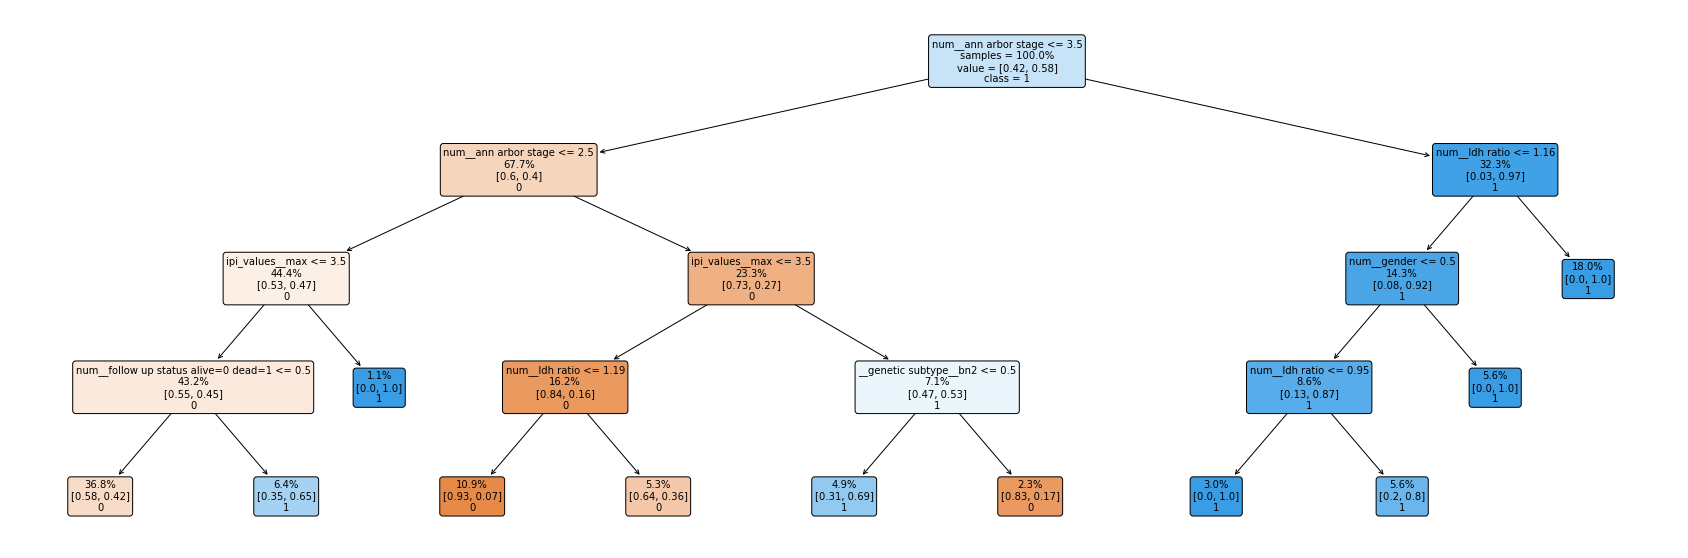

Validation AUC: 0.770
Validation Accuracy: 0.691


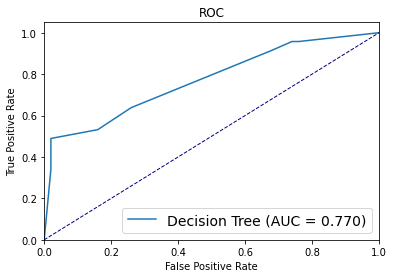

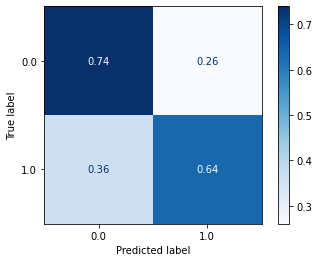

In [78]:
classifier = DecisionTreeClassifier
params = {'max_depth':[3,4,5,6,7], 'criterion':['gini','entropy'],'max_features':[None,'auto'],'min_samples_leaf':[2,3,4,5]}
clf_model = GridSearchCV(classifier(), param_grid=params, scoring = 'roc_auc', cv=6,n_jobs=-1)
clf_model.fit(X_train_for_DT, y_train_for_DT.values.ravel())

# Run the model with the best parameters
best_params = clf_model.best_params_
print('Best parameters are: {}'.format(best_params))
print('AVG Train AUC: {:.3f}'.format(clf_model.best_score_))                     

model_for_pred = classifier(**best_params)

model_for_pred.fit(X_train_for_DT,y_train_for_DT.values.ravel())


fig, ax = plt.subplots(figsize=(30, 10))
tree.plot_tree(model_for_pred,rounded=True,filled=True,precision=2,proportion= True,label='root',class_names=['0','1'],impurity=False,feature_names=X_train_for_DT.columns, fontsize=10)

# Plot & Save Decision support system
plt.savefig('Decision_support_system_DT_for_doctors.png')
plt.show()

y_pred = model_for_pred.predict_proba(X_test_for_DT)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test_labeled, y_pred, pos_label=1)
auc = metrics.auc(fpr,tpr)
accuracy_score = metrics.accuracy_score(y_test_labeled, np.round(y_pred))
print('Validation AUC: {:.3f}'.format(auc))                     
print('Validation Accuracy: {:.3f}'.format(accuracy_score))
#----- Plots -----

# Plot ROC
lw=1
plt.figure()
plt.plot(fpr,tpr,label='Decision Tree (AUC = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right",fontsize=14)

plt.show()

# Plot Confusion Matrix
metrics.ConfusionMatrixDisplay.from_estimator(model_for_pred,X_test_for_DT,y_test_labeled,cmap=plt.cm.Blues, normalize='true')

plt.show()


## Test Score Cell

In [80]:
'''
all you need to do in order to get the test AUC id toreplace with your test file_name
make sure all the observation in the test file hava non-null values in the "number of extranodal sites" so we can calculate the score
'''
file_name = "C:\\Users\\PC\\Downloads\\labeled_obervations.csv" 

transformer = pickle.load(open('feature_transformer.pkl', 'rb'))
scaler = pickle.load(open('minmaxScalerX.pkl', 'rb'))
rf_classifier = pickle.load(open('finalized_RF_model.sav', 'rb'))
test_df = pd.read_csv(file_name)
test_df.rename(columns={"Treatment__": "Treatment", "Status at Follow_up_ 0 Alive_ 1 Dead": "Follow up Status Alive=0 Dead=1", "Follow_up Time _yrs": "Follow up Time (yrs)", "Progression_Free Survival _PFS_ Status_ 0 No Progressoin_ 1 Progression": "PFS Status No Progress=0 Progress=1", "Progression_Free Survival _PFS_ Time _yrs": "PFS (yrs)"}, inplace=True)
df_after_preprocessing, y = Initial_pre_processing_Transformer.transform(test_df)
x_transformed = pd.DataFrame(transformer.transform(df_after_preprocessing).A,index=df_after_preprocessing.index,columns=X_train_labeled.columns)
X_scaled = pd.DataFrame(scaler.transform(x_transformed),columns=x_transformed.columns)
yhat = rf_classifier.predict(X_scaled.to_numpy())
# evaluate auc
fpr, tpr, thresholds = metrics.roc_curve(y.ravel(), yhat, pos_label=1)
auc = metrics.auc(fpr,tpr)
print(auc)